In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

## Simple linear regression

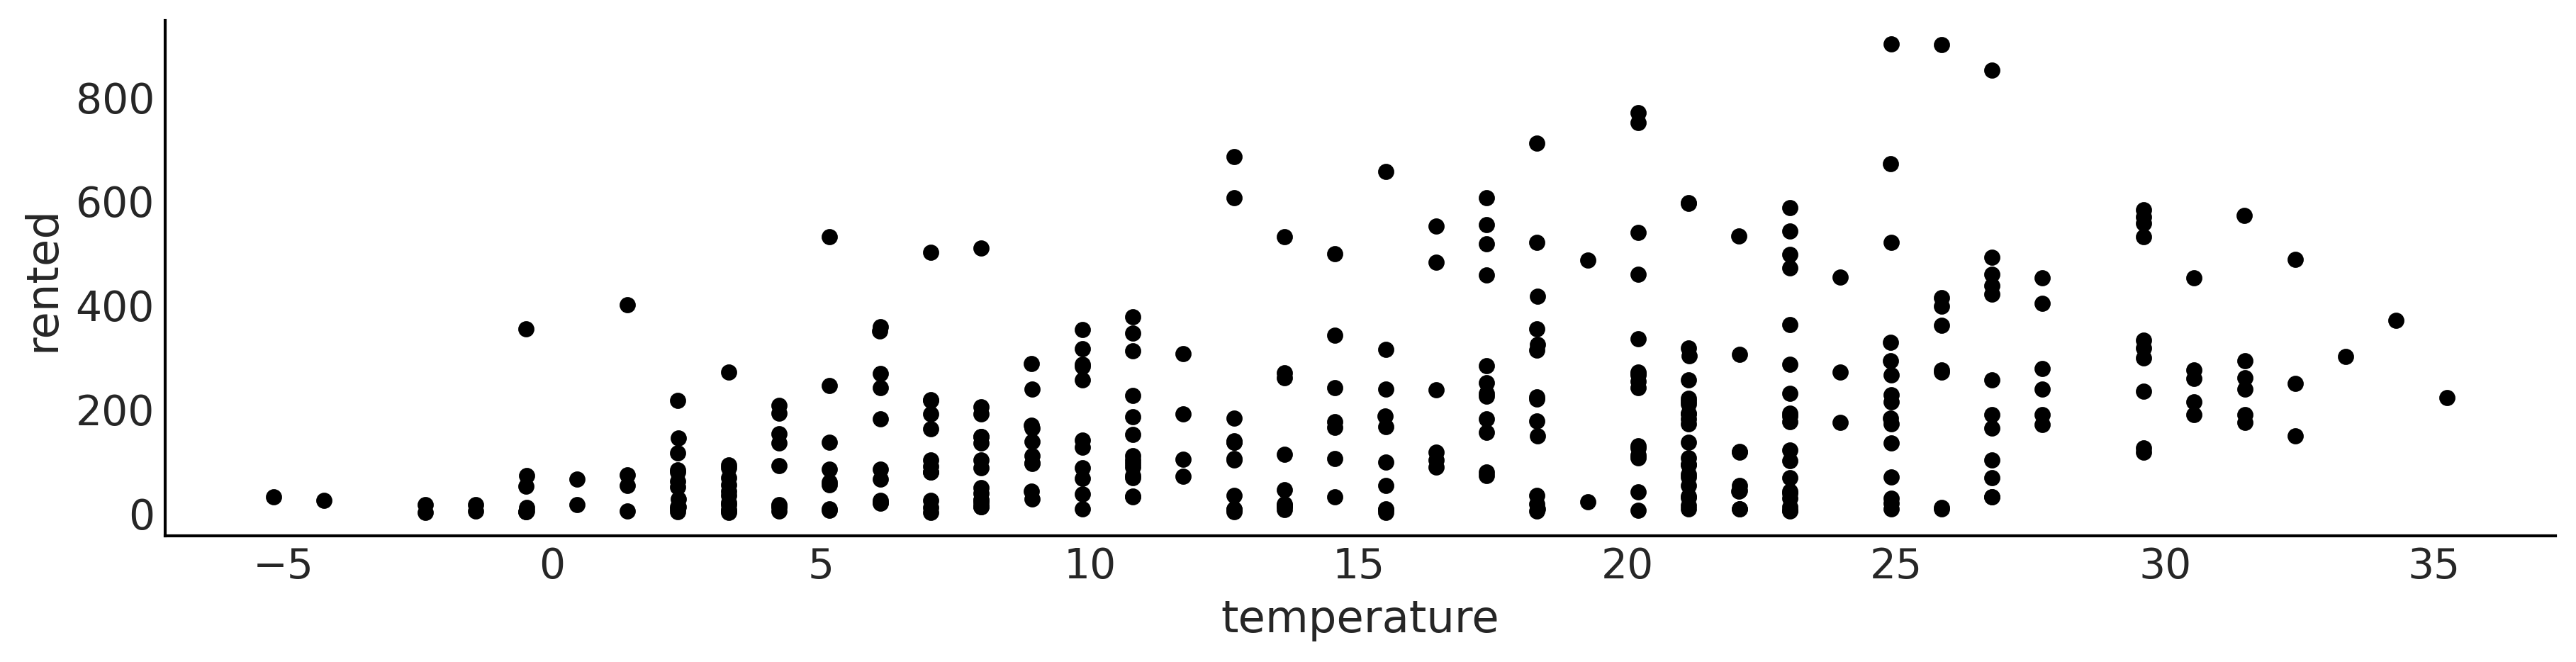

In [3]:
bikes = pd.read_csv("data/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")
plt.savefig("../fig/bike_temperature.png")

In [4]:
with pm.Model() as model_lb:
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfCauchy("σ", 10)
    μ = pm.Deterministic("μ", α + β * bikes.temperature)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented)
    idata_lb = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [5]:
# graph = pm.model_to_graphviz(model_lb)
# graph.graph_attr.update(size="4,4!")
# graph.graph_attr.update(dpi="300")
# graph.render(filename="../fig/linear_bikes_dag", format="png", cleanup=True)

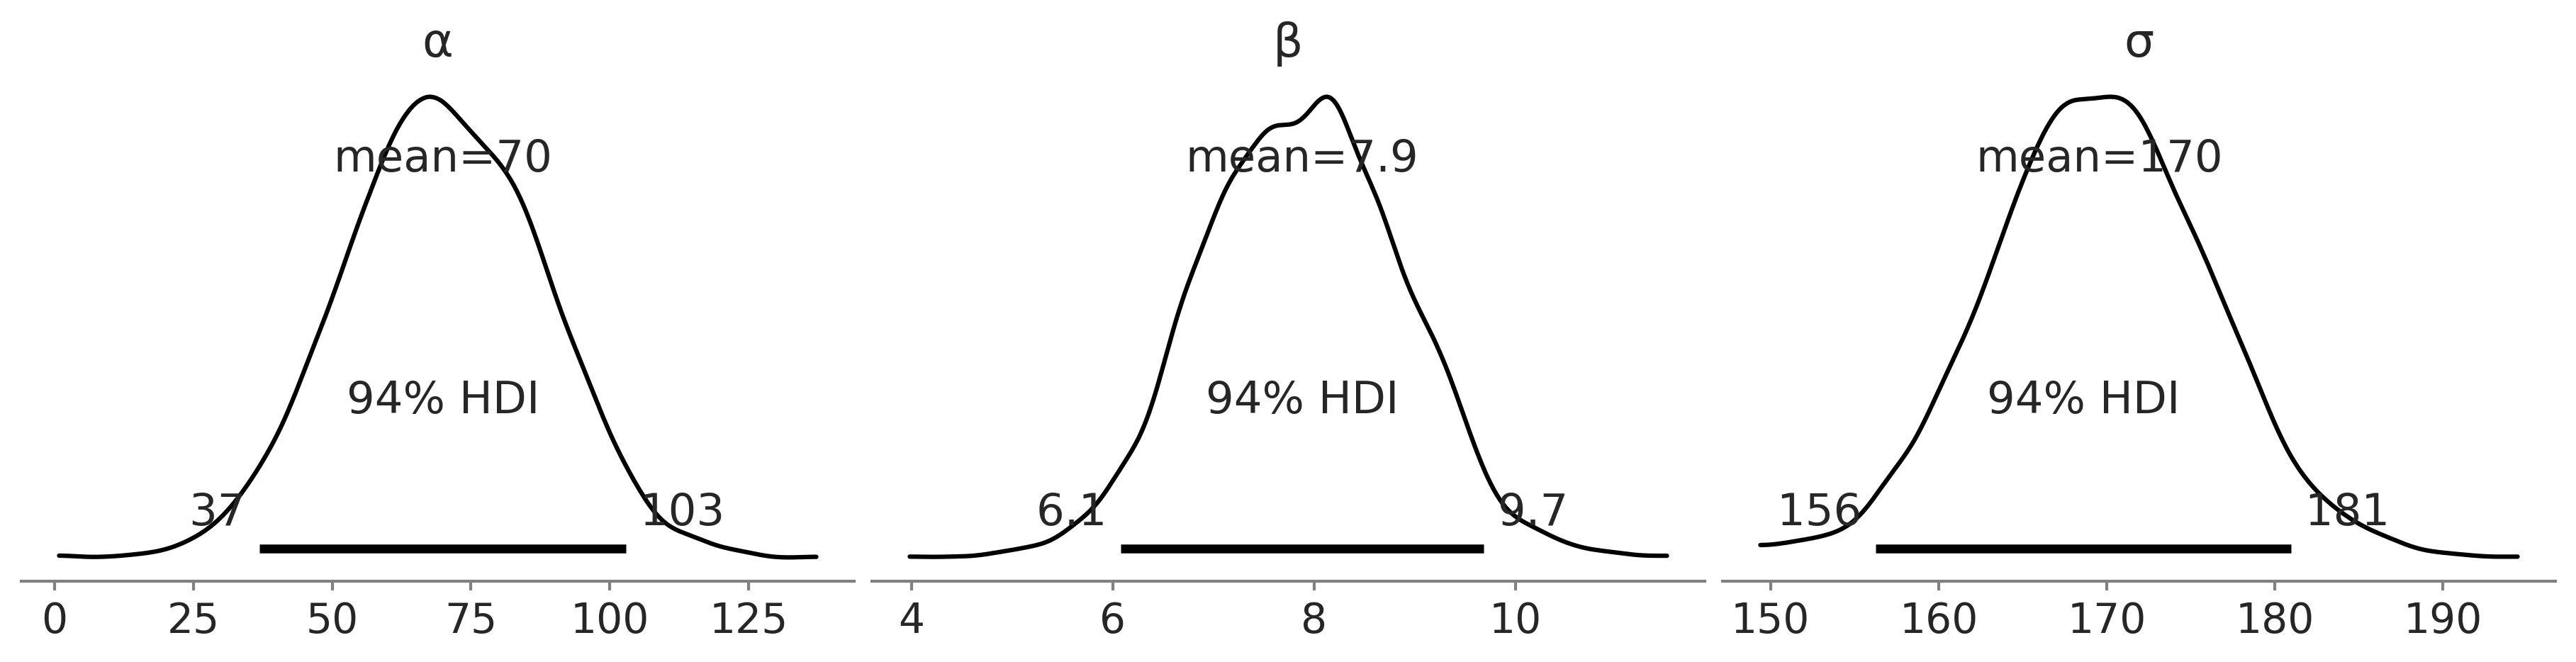

In [6]:
# fmt: off
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))
plt.savefig("../fig/linear_bikes_posterior.png")

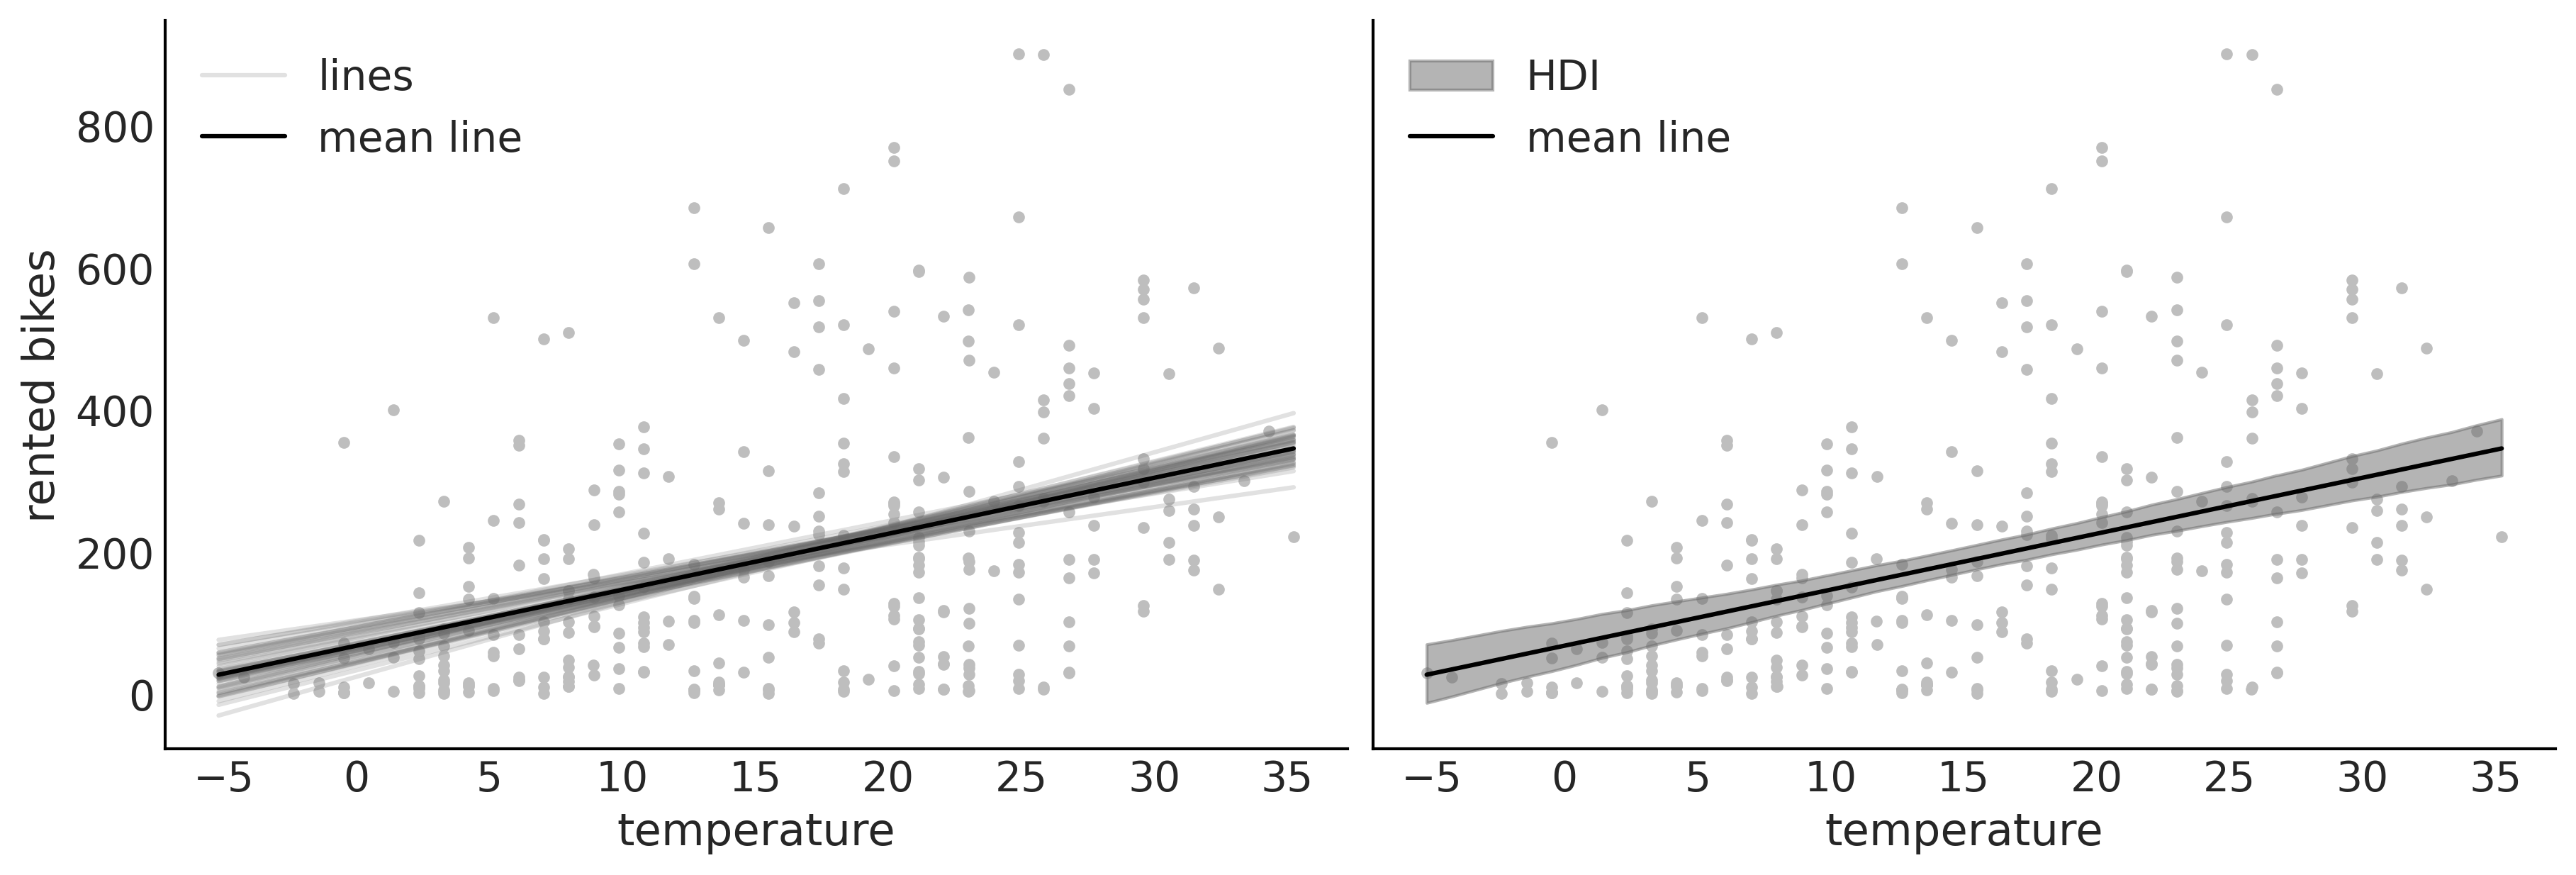

In [7]:
posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id"
)
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot
lines = posterior["α"] + posterior["β"] * x_plot
hdi_lines = az.hdi(idata_lb.posterior["μ"])


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, mean_line, c="C0", label="mean line")
axes[0].set_xlabel("temperature")
axes[0].set_ylabel("rented bikes")
axes[0].legend()

axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
idx = np.argsort(bikes.temperature.values)
axes[1].fill_between(
    bikes.temperature[idx],
    hdi_lines["μ"][:, 0][idx],
    hdi_lines["μ"][:, 1][idx],
    color="C1",
    label="HDI",
    alpha=0.5,
)
axes[1].plot(x_plot, mean_line, c="C0", label="mean line")
axes[1].set_xlabel("temperature")
axes[1].legend()
plt.savefig("../fig/linear_bikes_posterior_lines.png")

In [8]:
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True)

Sampling: [y_pred]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

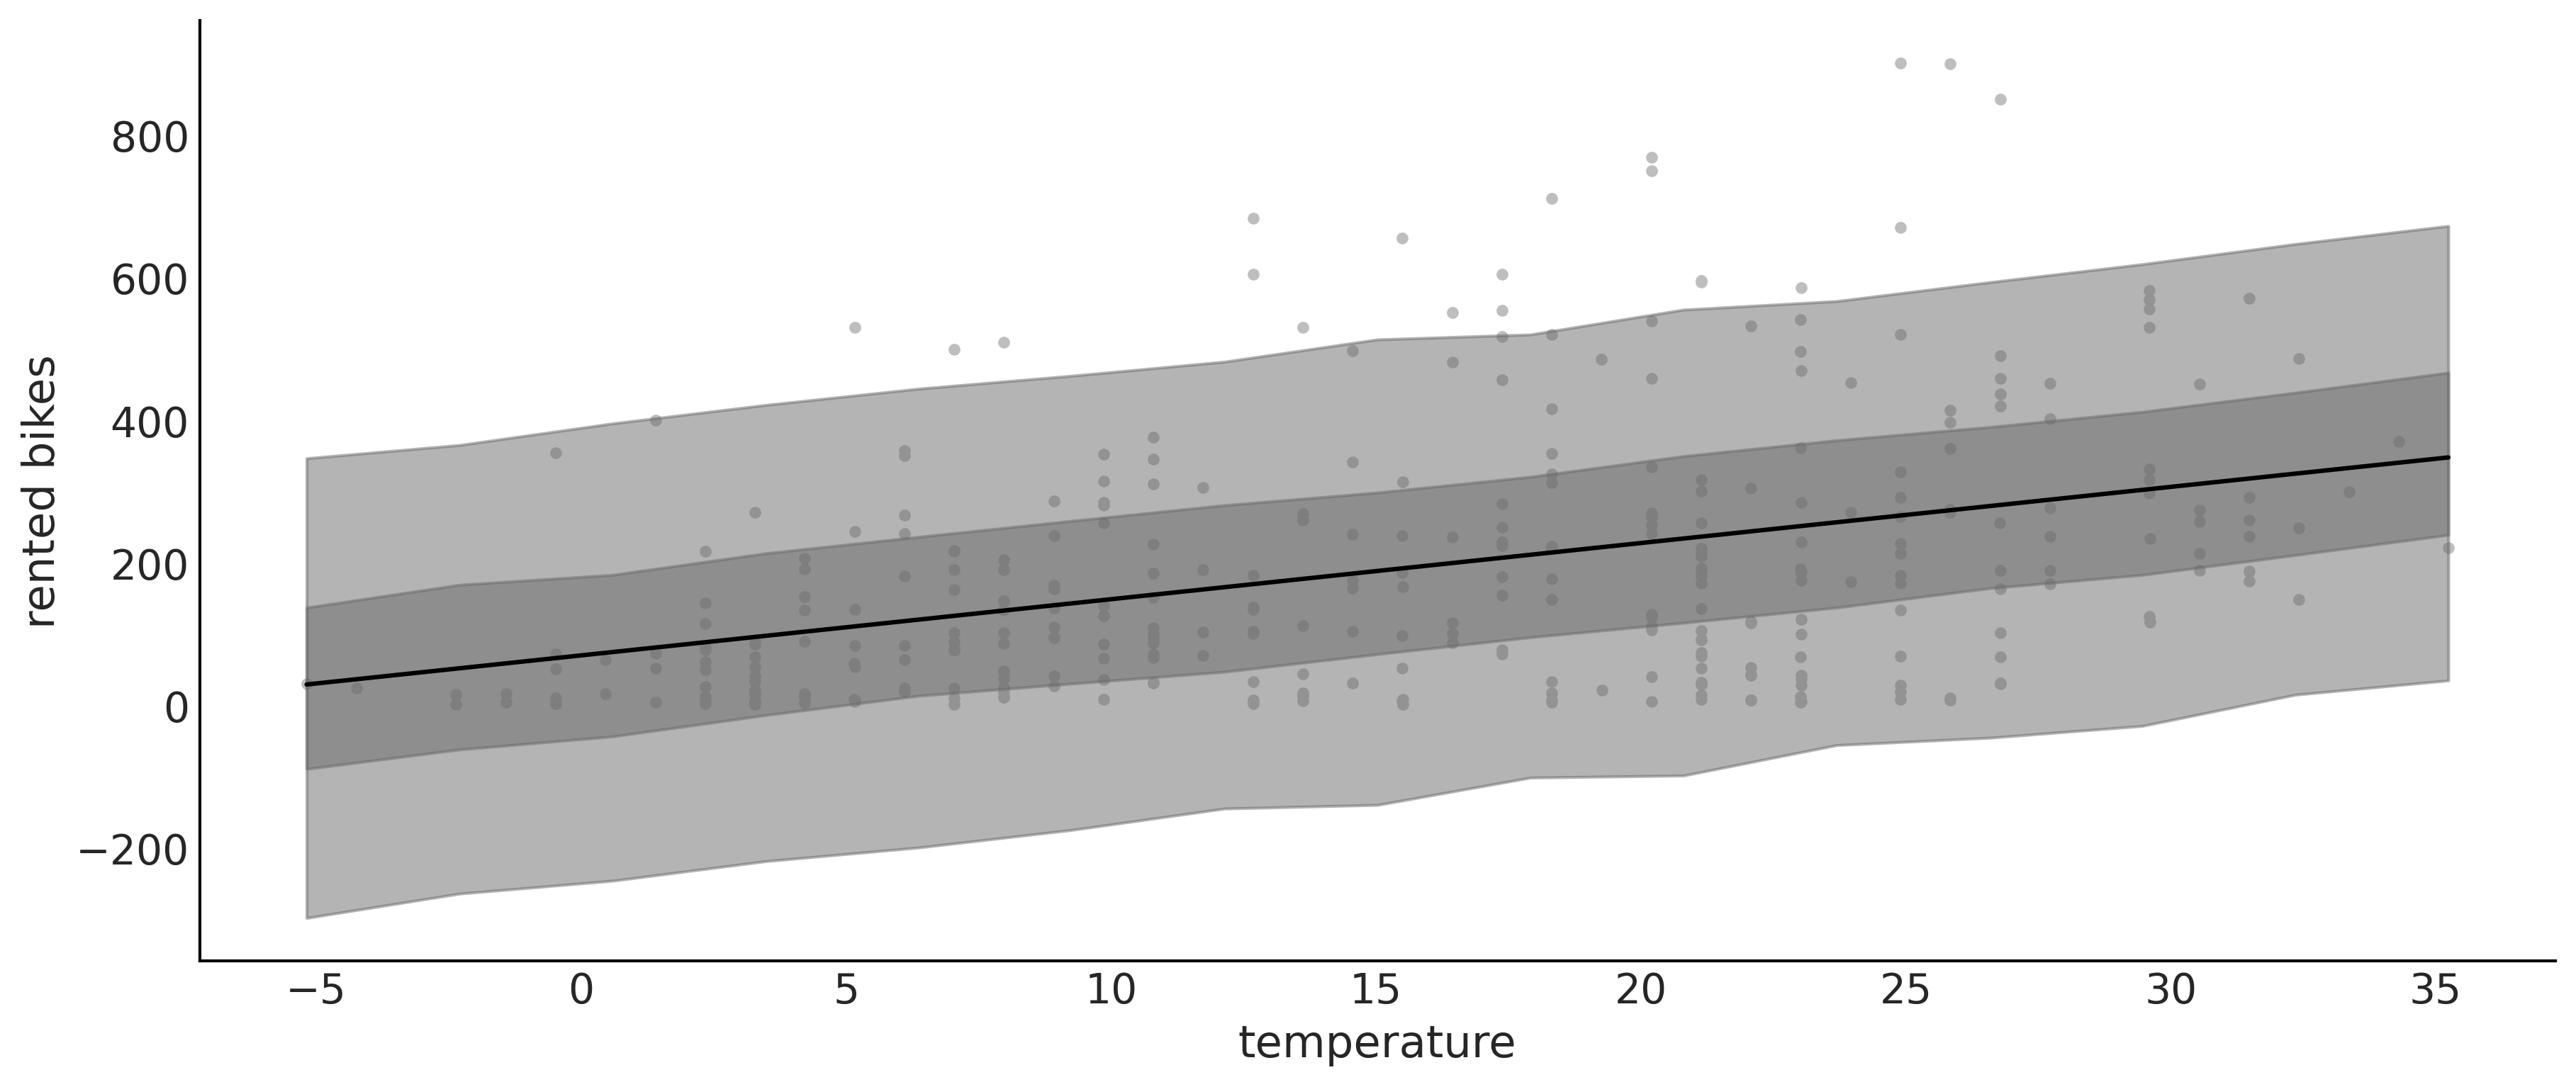

In [9]:
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))
idx = np.argsort(bikes.temperature.values)
x = np.linspace(bikes.temperature.min(), bikes.temperature.max(), 15)
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(bikes.temperature.values[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)


ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")
plt.savefig("../fig/linear_bikes_posterior_predictive.png")

## Counting Bikes

In [10]:
with pm.Model() as model_neg:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Deterministic("μ", pm.math.exp(α + β * bikes.temperature))
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=bikes.rented)
    idata_neg = pm.sample(random_seed=123)
    idata_neg.extend(pm.sample_posterior_predictive(idata_neg, random_seed=123))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [y_pred]


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

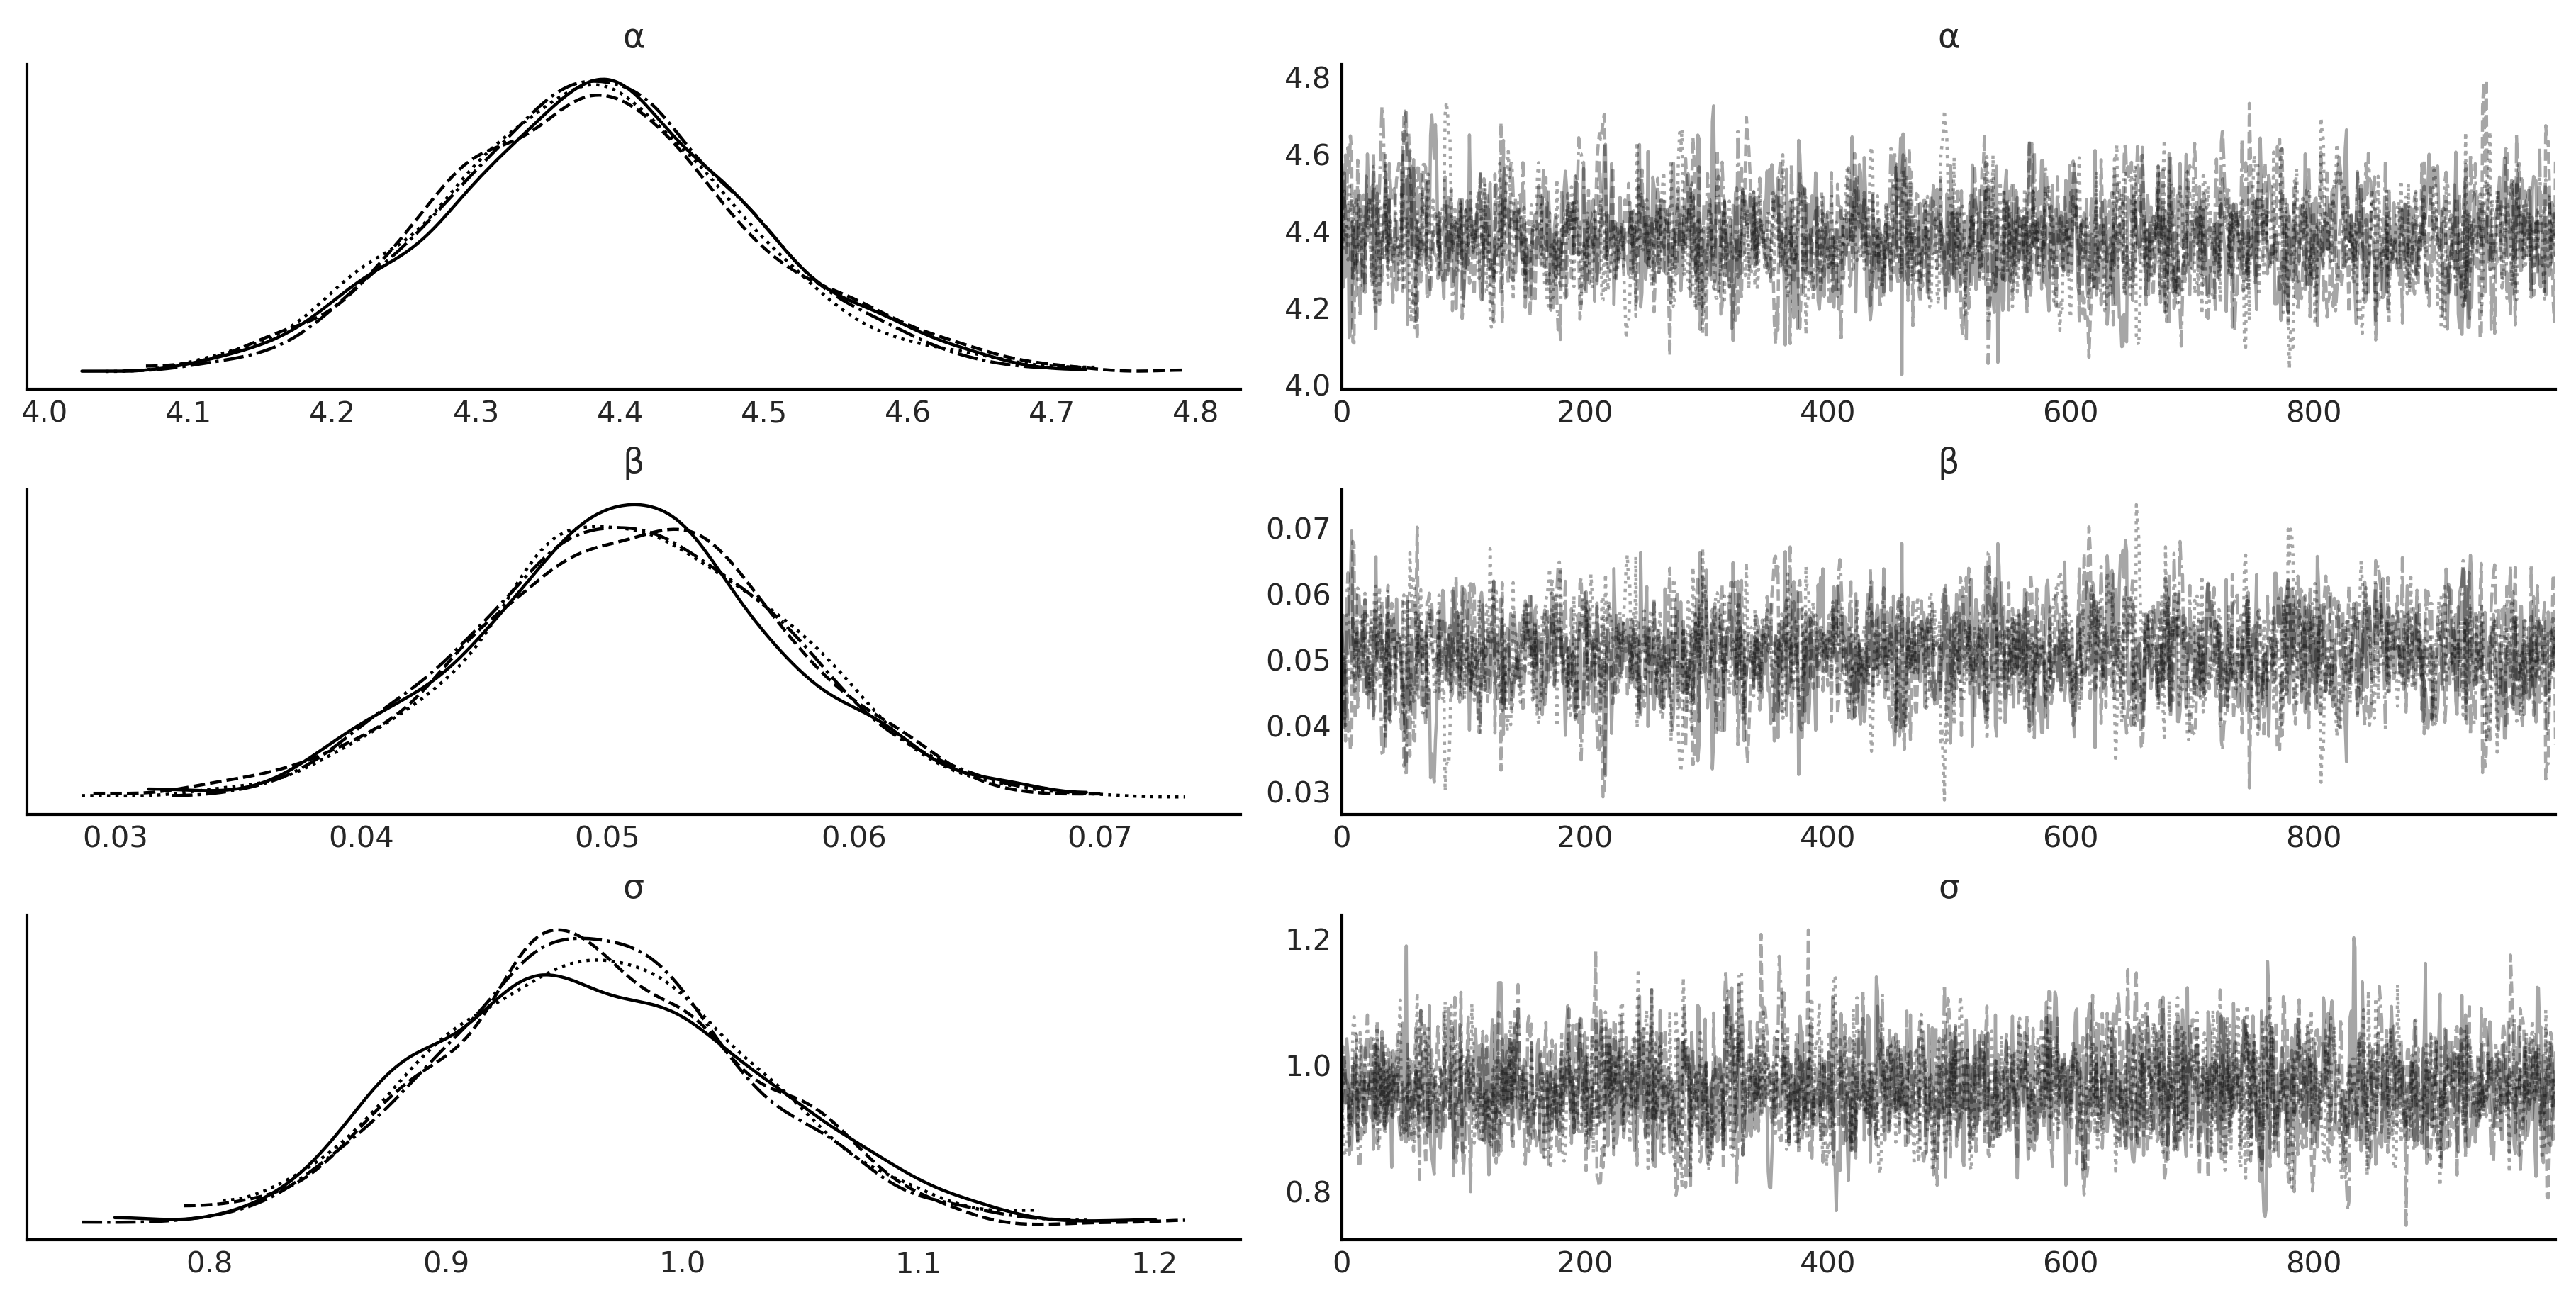

In [11]:
az.plot_trace(idata_neg, var_names=["~μ"])

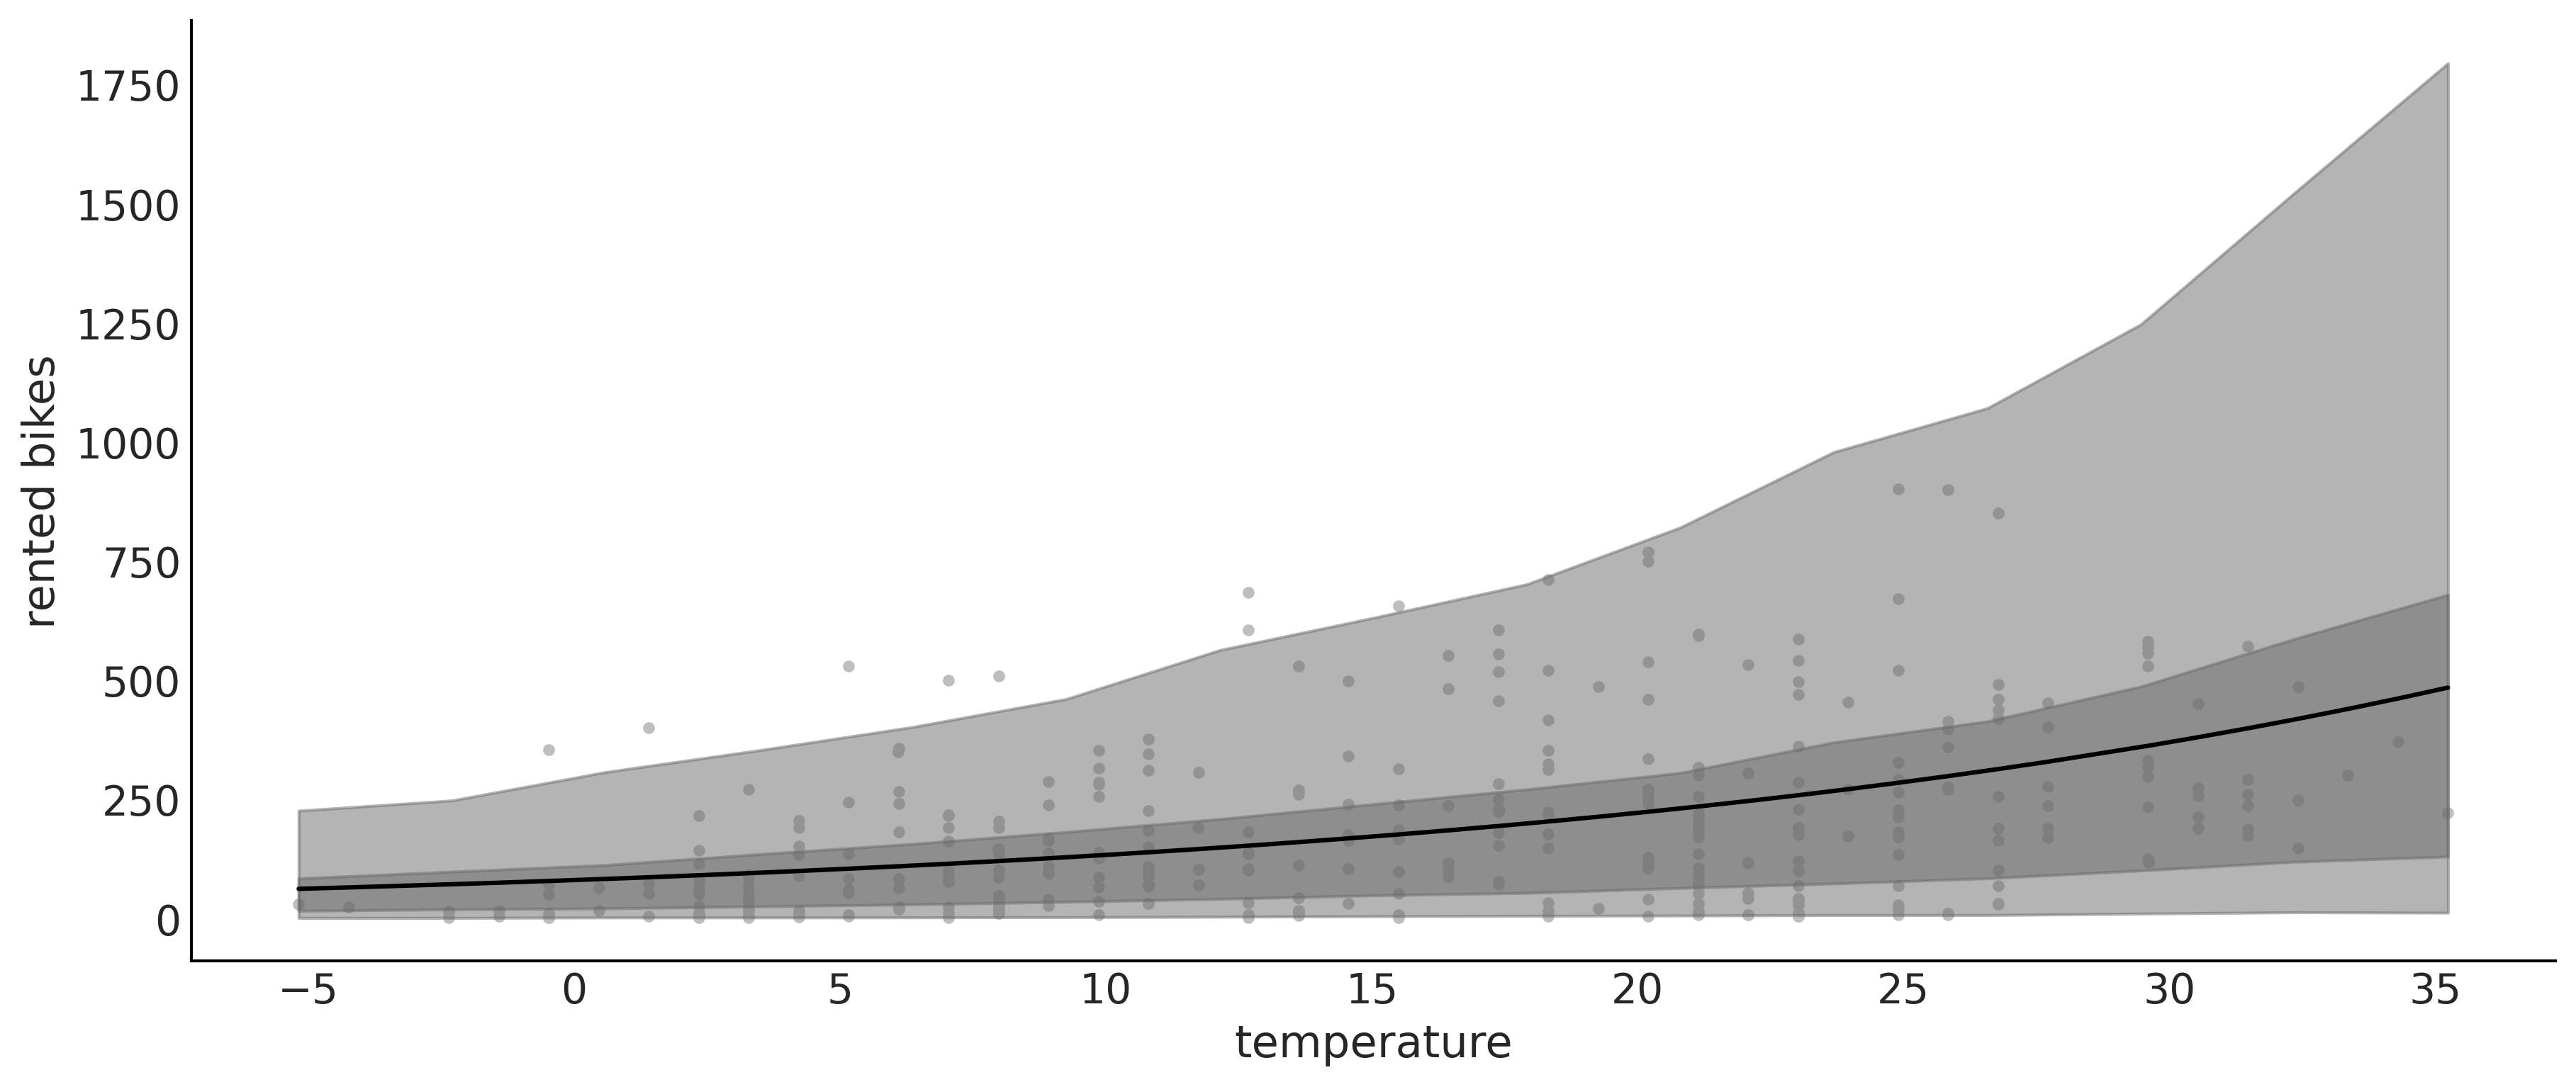

In [12]:
mean_line = idata_neg.posterior["μ"].mean(("chain", "draw"))
idx = np.argsort(bikes.temperature.values)
x = np.linspace(bikes.temperature.min(), bikes.temperature.max(), 15)
y_pred_q = idata_neg.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(bikes.temperature.values[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")
plt.savefig("../fig/linear_bikes_posterior_predictive_nb.png")

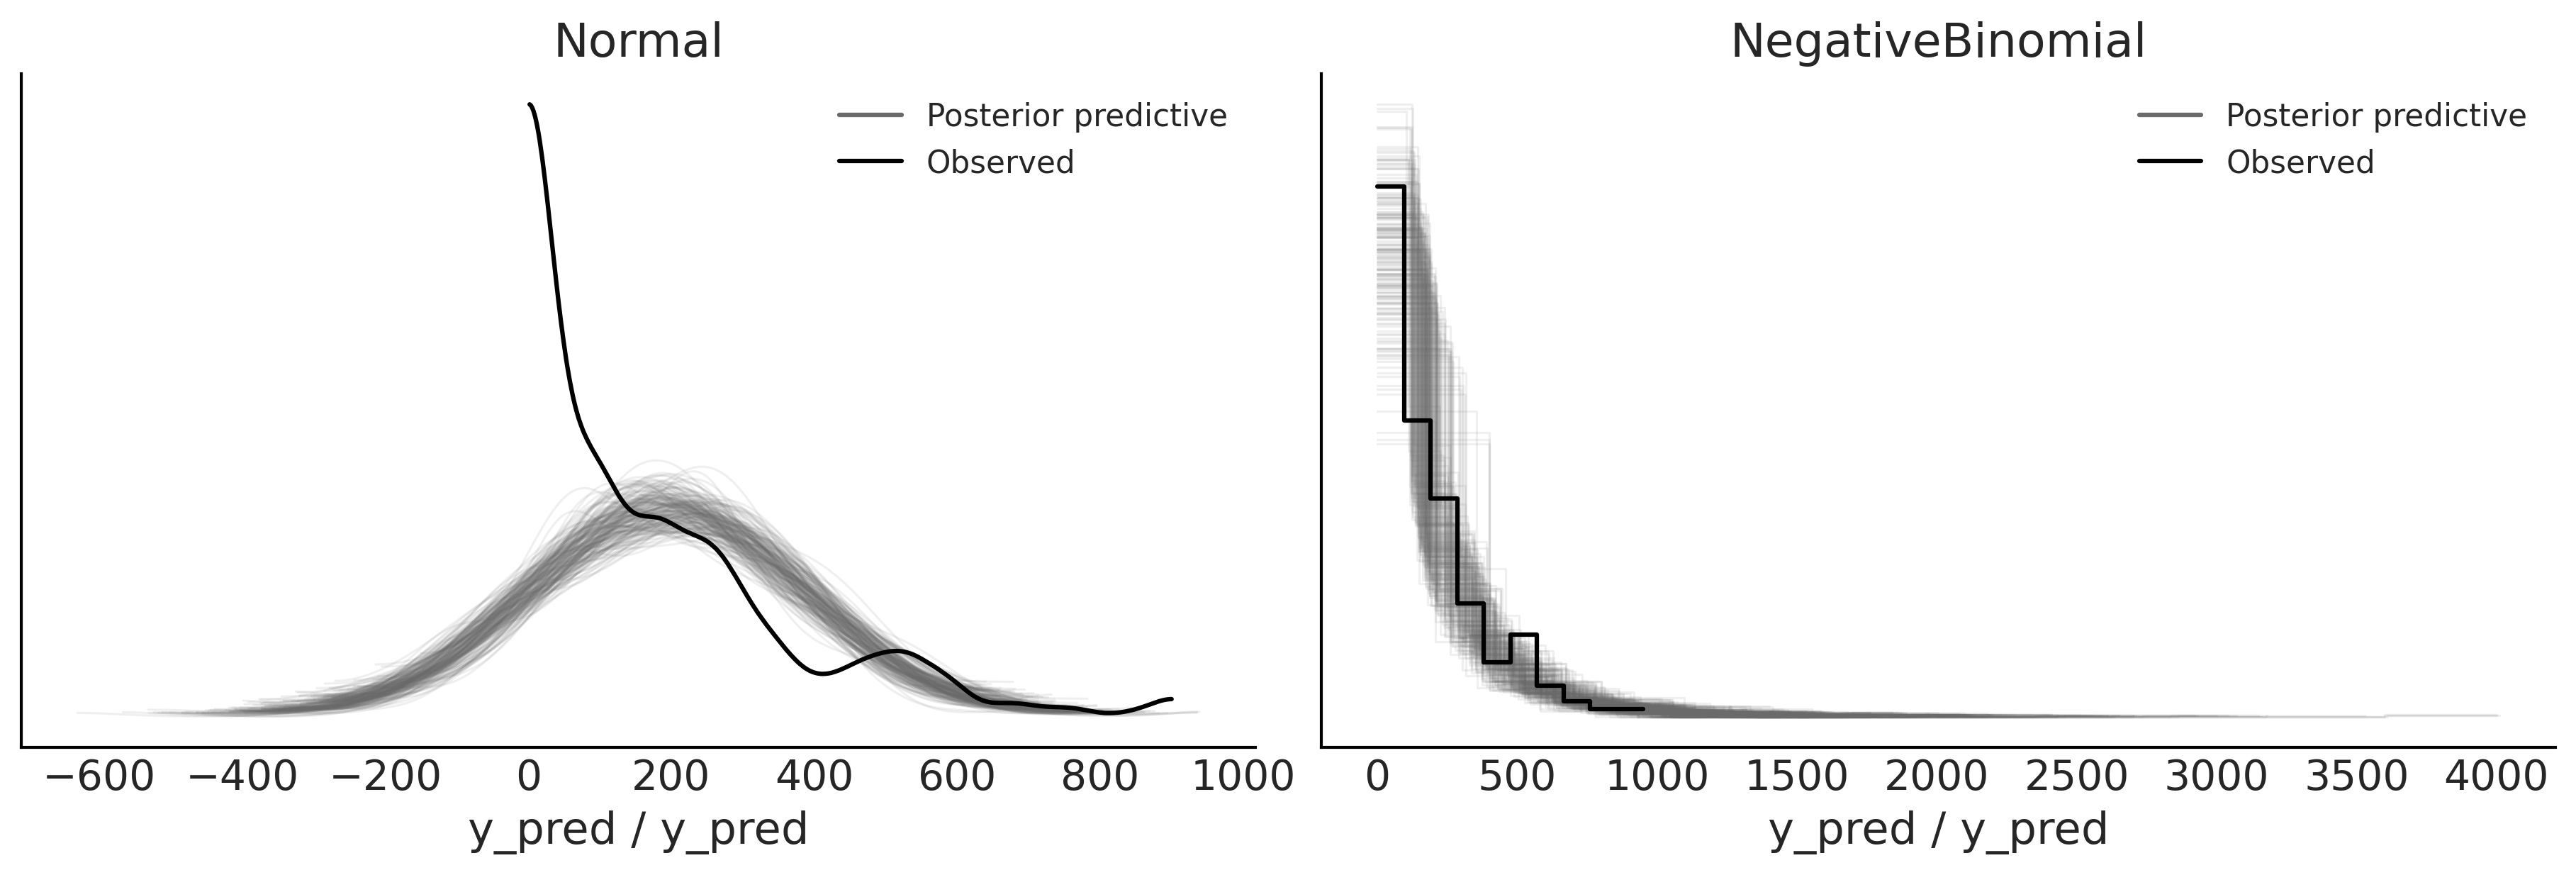

In [13]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_ppc(
    idata_lb,
    num_pp_samples=200,
    alpha=0.1,
    colors=["C1", "C0", "C0"],
    ax=ax[0],
    mean=False,
)
az.plot_ppc(
    idata_neg,
    num_pp_samples=200,
    alpha=0.1,
    colors=["C1", "C0", "C0"],
    ax=ax[1],
    mean=False,
)
ax[0].set_title("Normal")
ax[1].set_title("NegativeBinomial")


plt.savefig("../fig/linear_bikes_posterior_predictive_check.png")

## Robust Regression

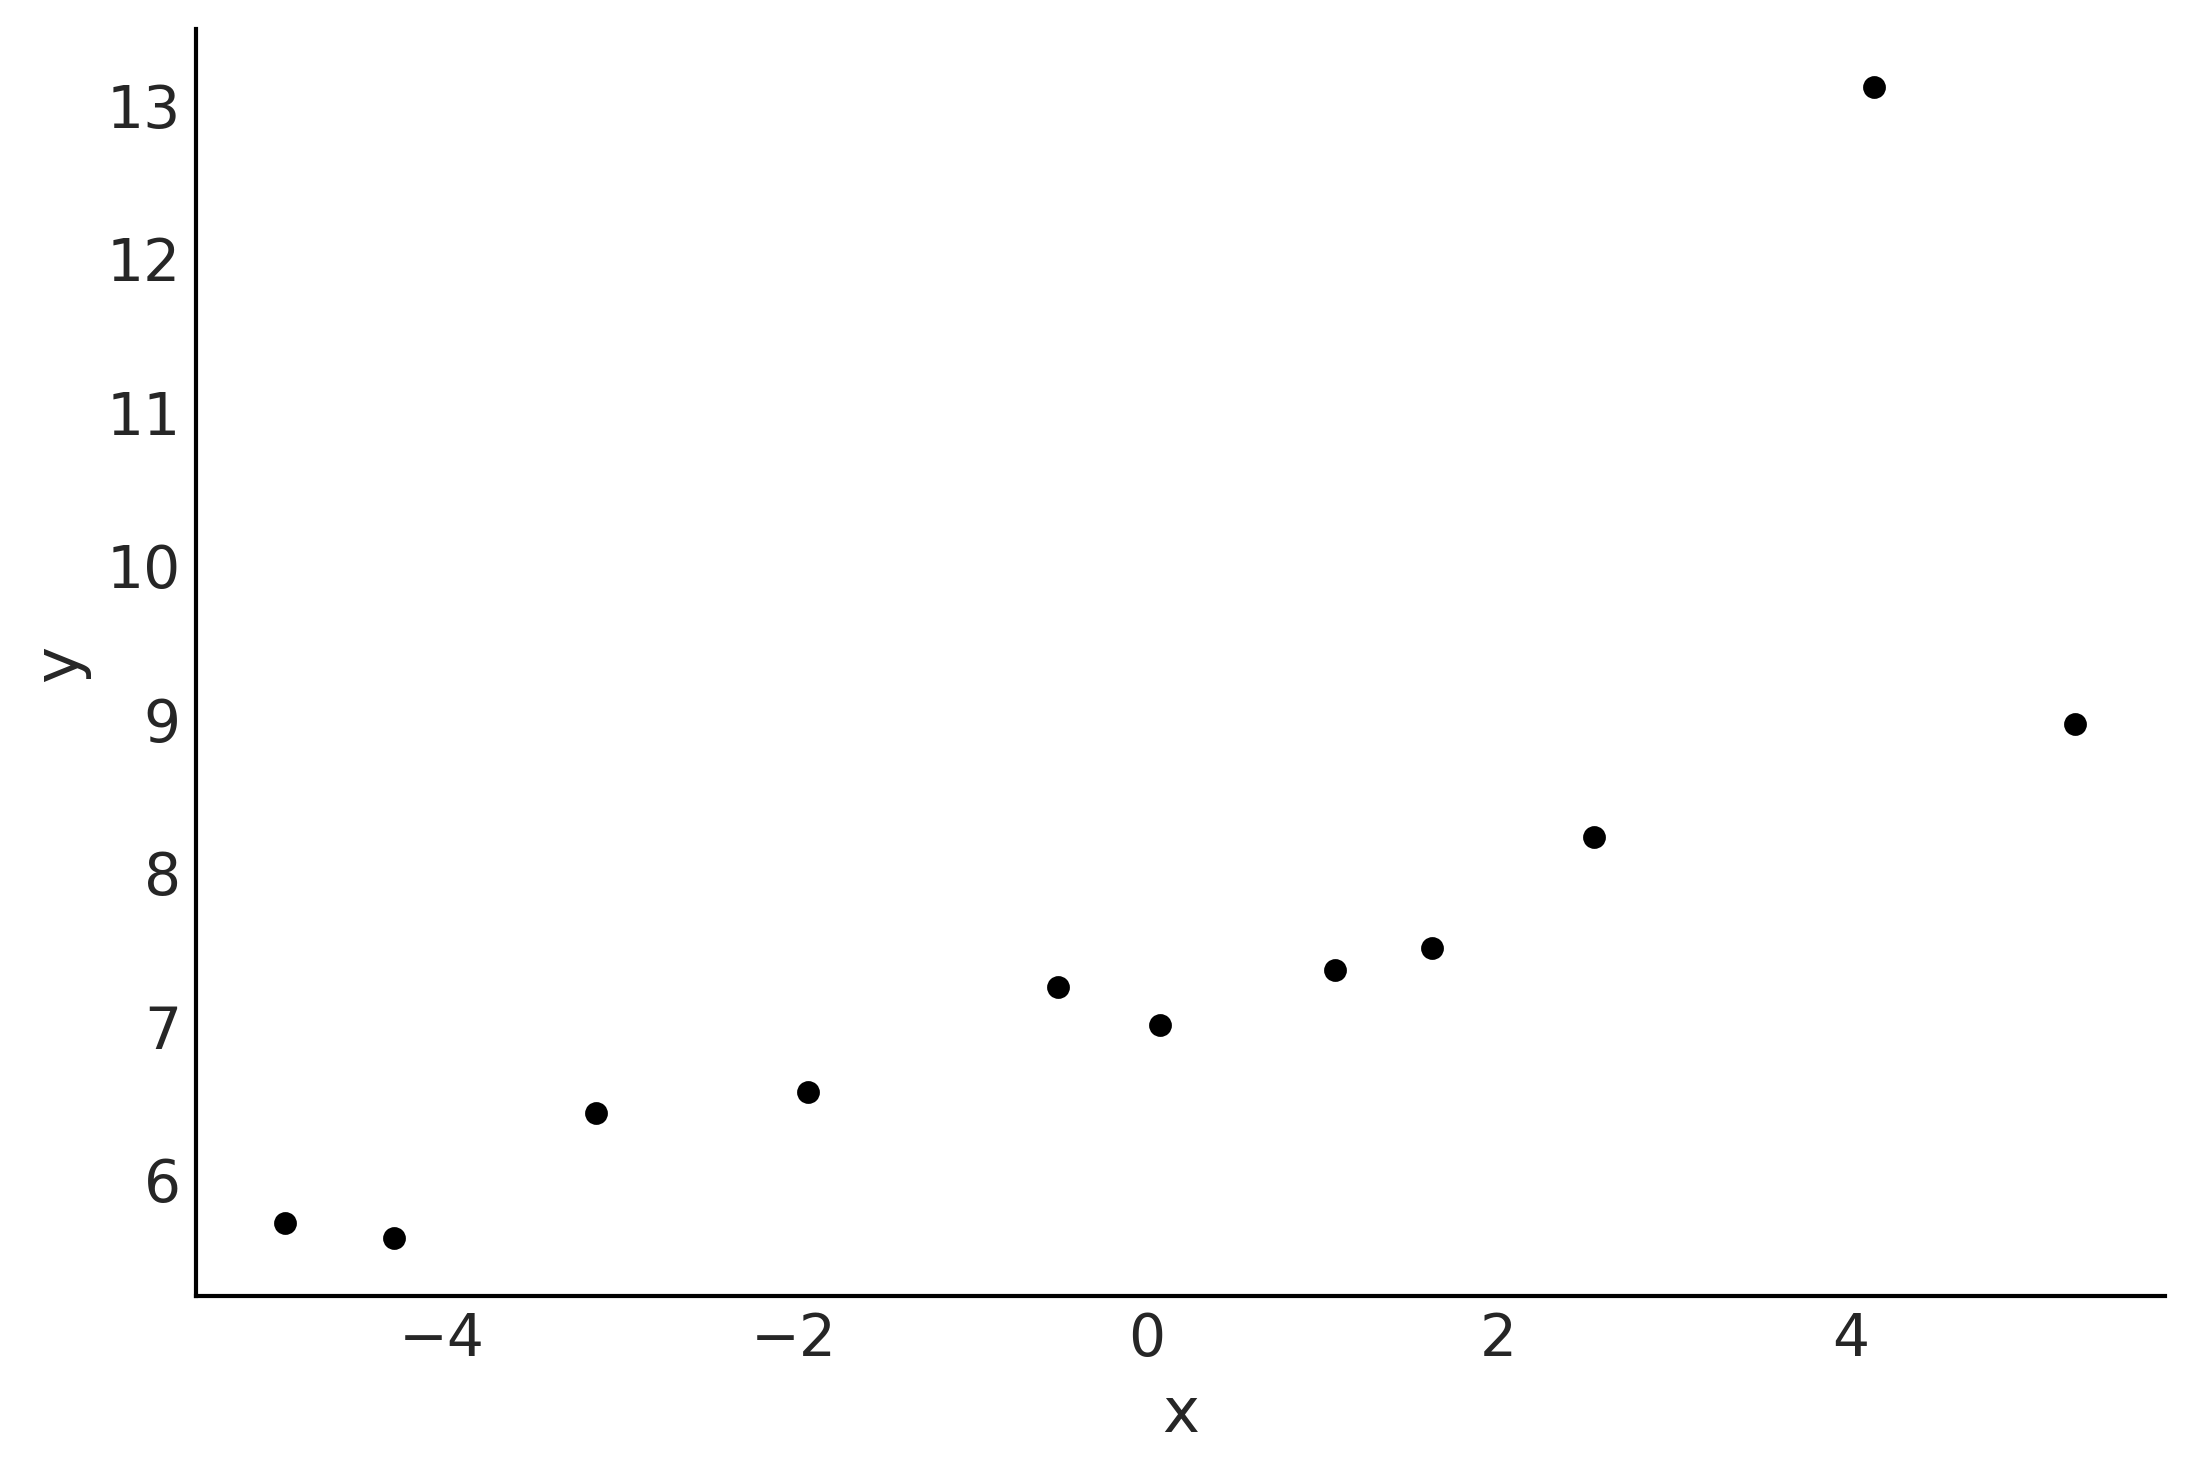

In [14]:
ans = pd.read_csv("data/anscombe_3.csv")
ans.plot("x", "y", kind="scatter");

In [15]:
with pm.Model() as model_t:
    α = pm.Normal("α", mu=ans.y.mean(), sigma=1)
    β = pm.Normal("β", mu=0, sigma=1)
    σ = pm.HalfNormal("σ", 5)
    ν_ = pm.Exponential("ν_", 1 / 29)
    ν = pm.Deterministic("ν", ν_ + 1)
    μ = pm.Deterministic("μ", α + β * ans.x)
    _ = pm.StudentT("y_pred", mu=μ, sigma=σ, nu=ν, observed=ans.y)

    idata_t = pm.sample(2000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ, ν_]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


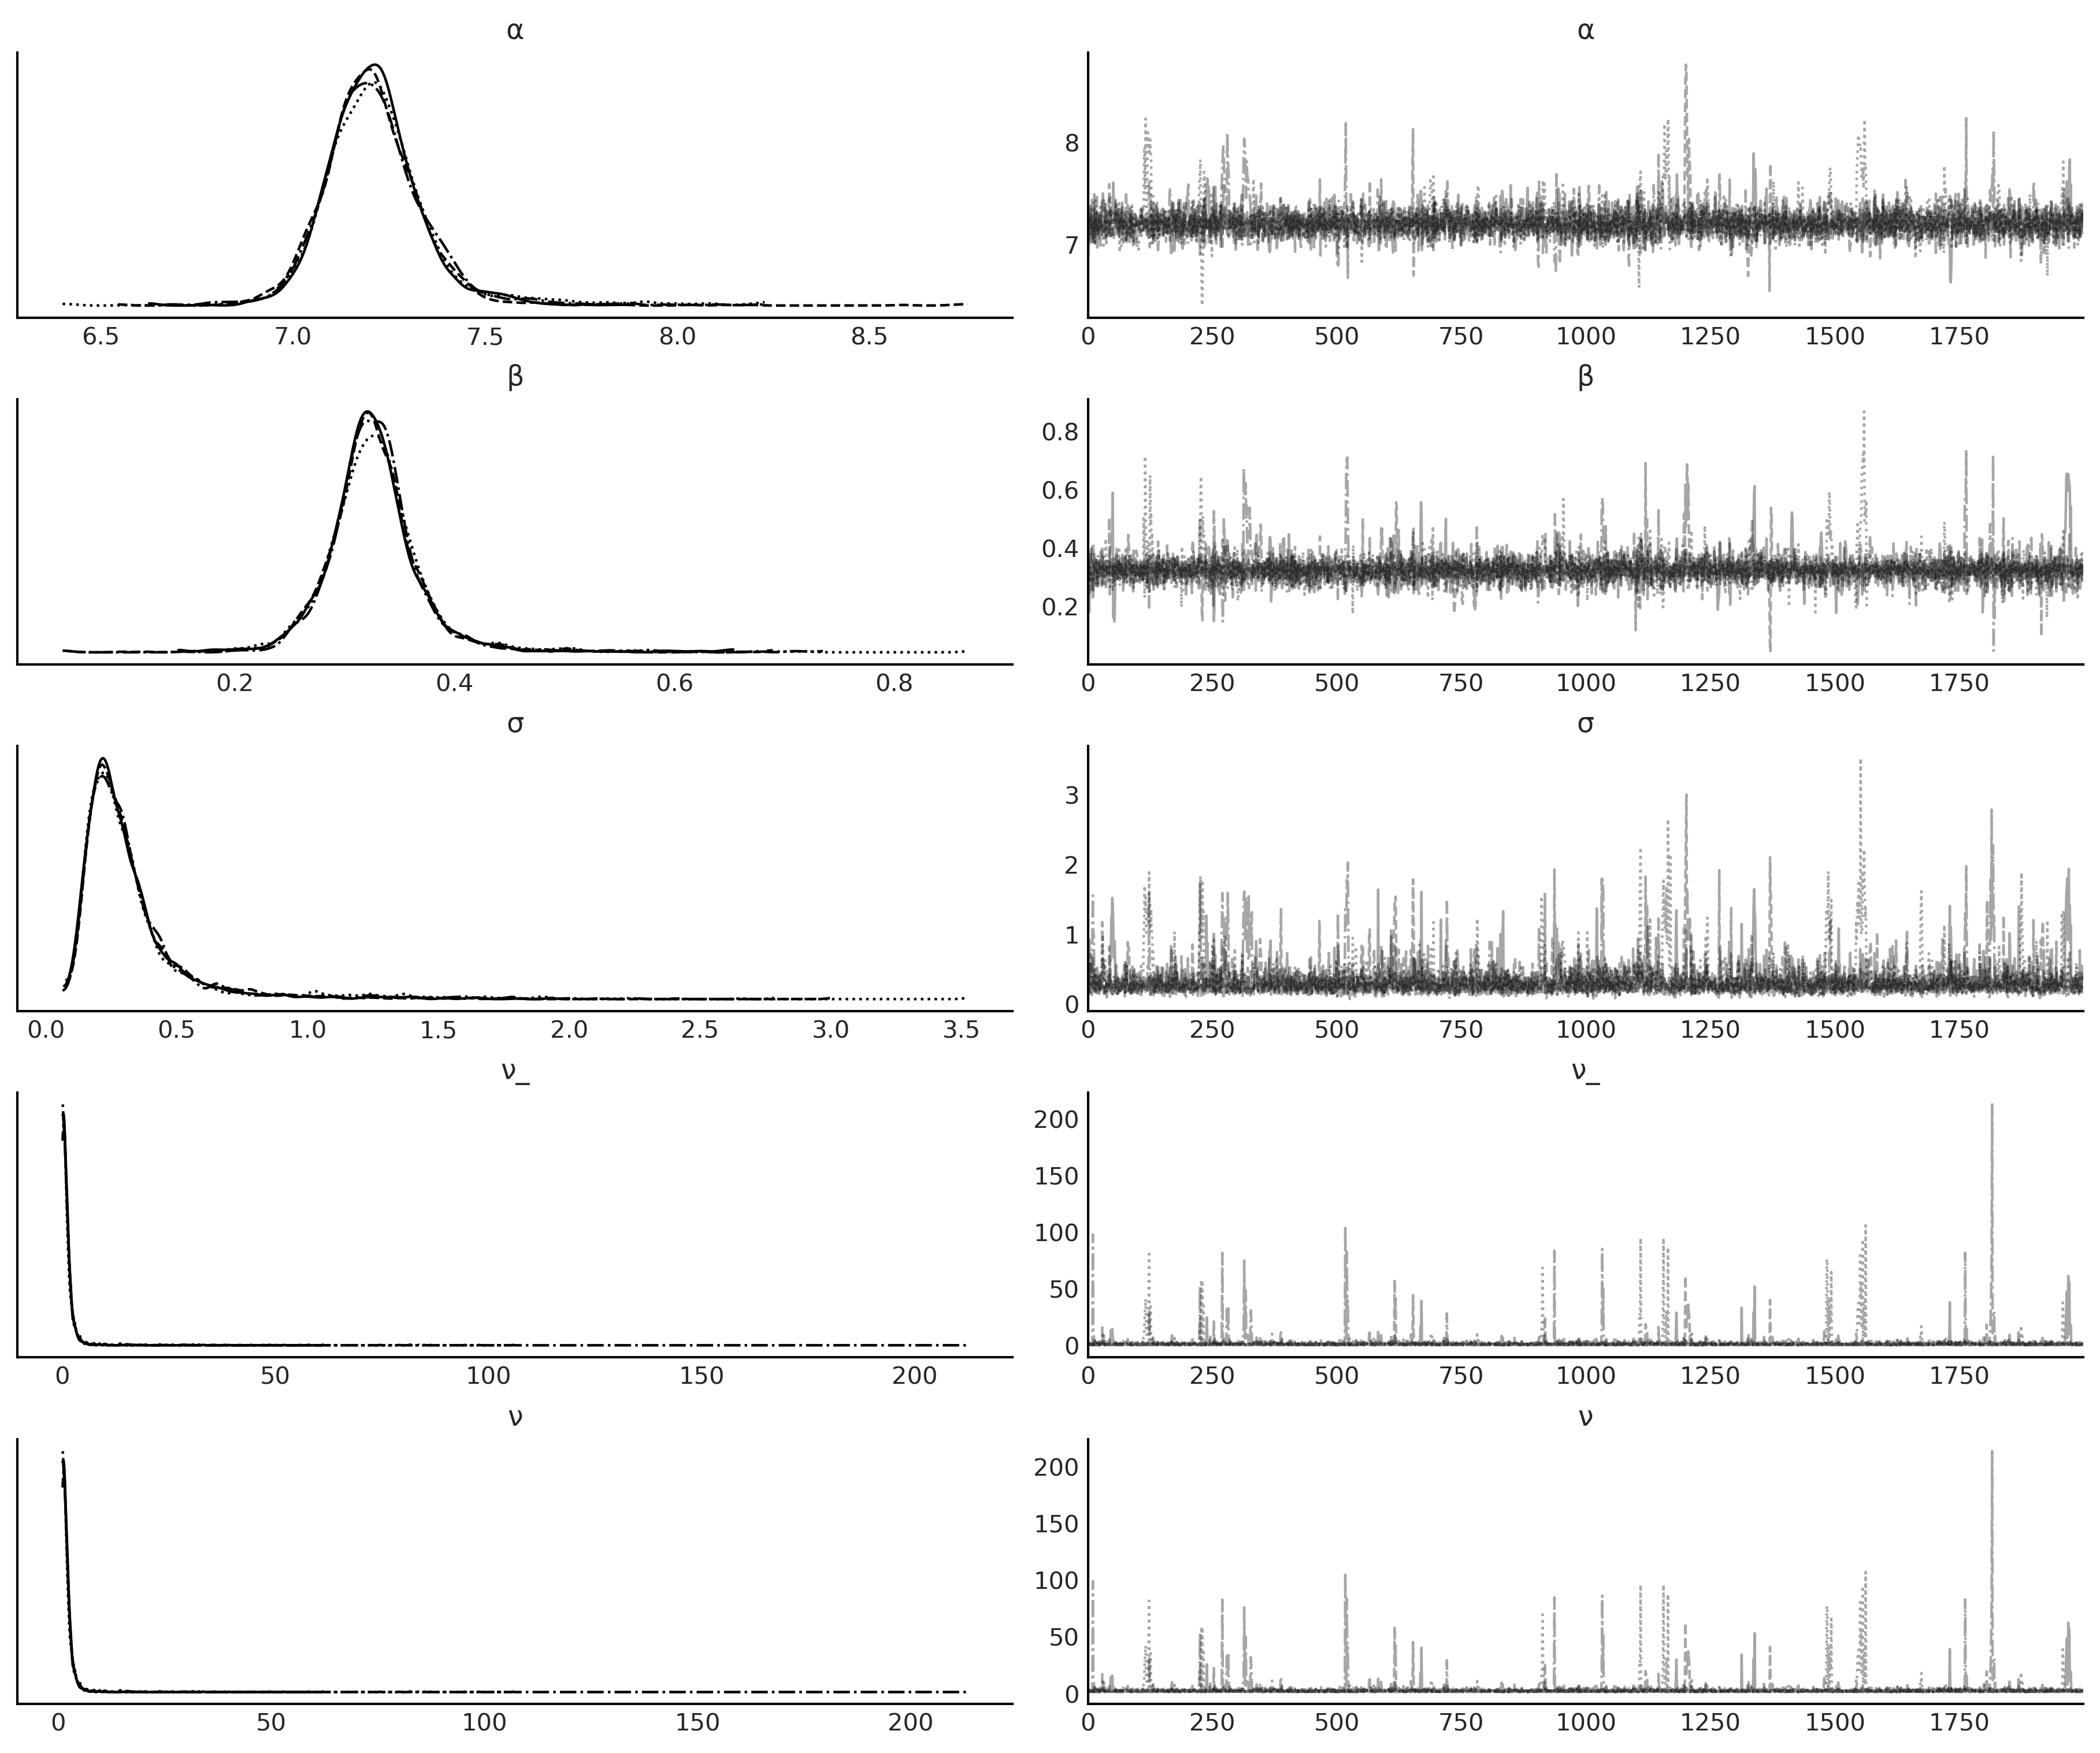

In [16]:
az.plot_trace(idata_t, var_names=["~μ"]);

/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


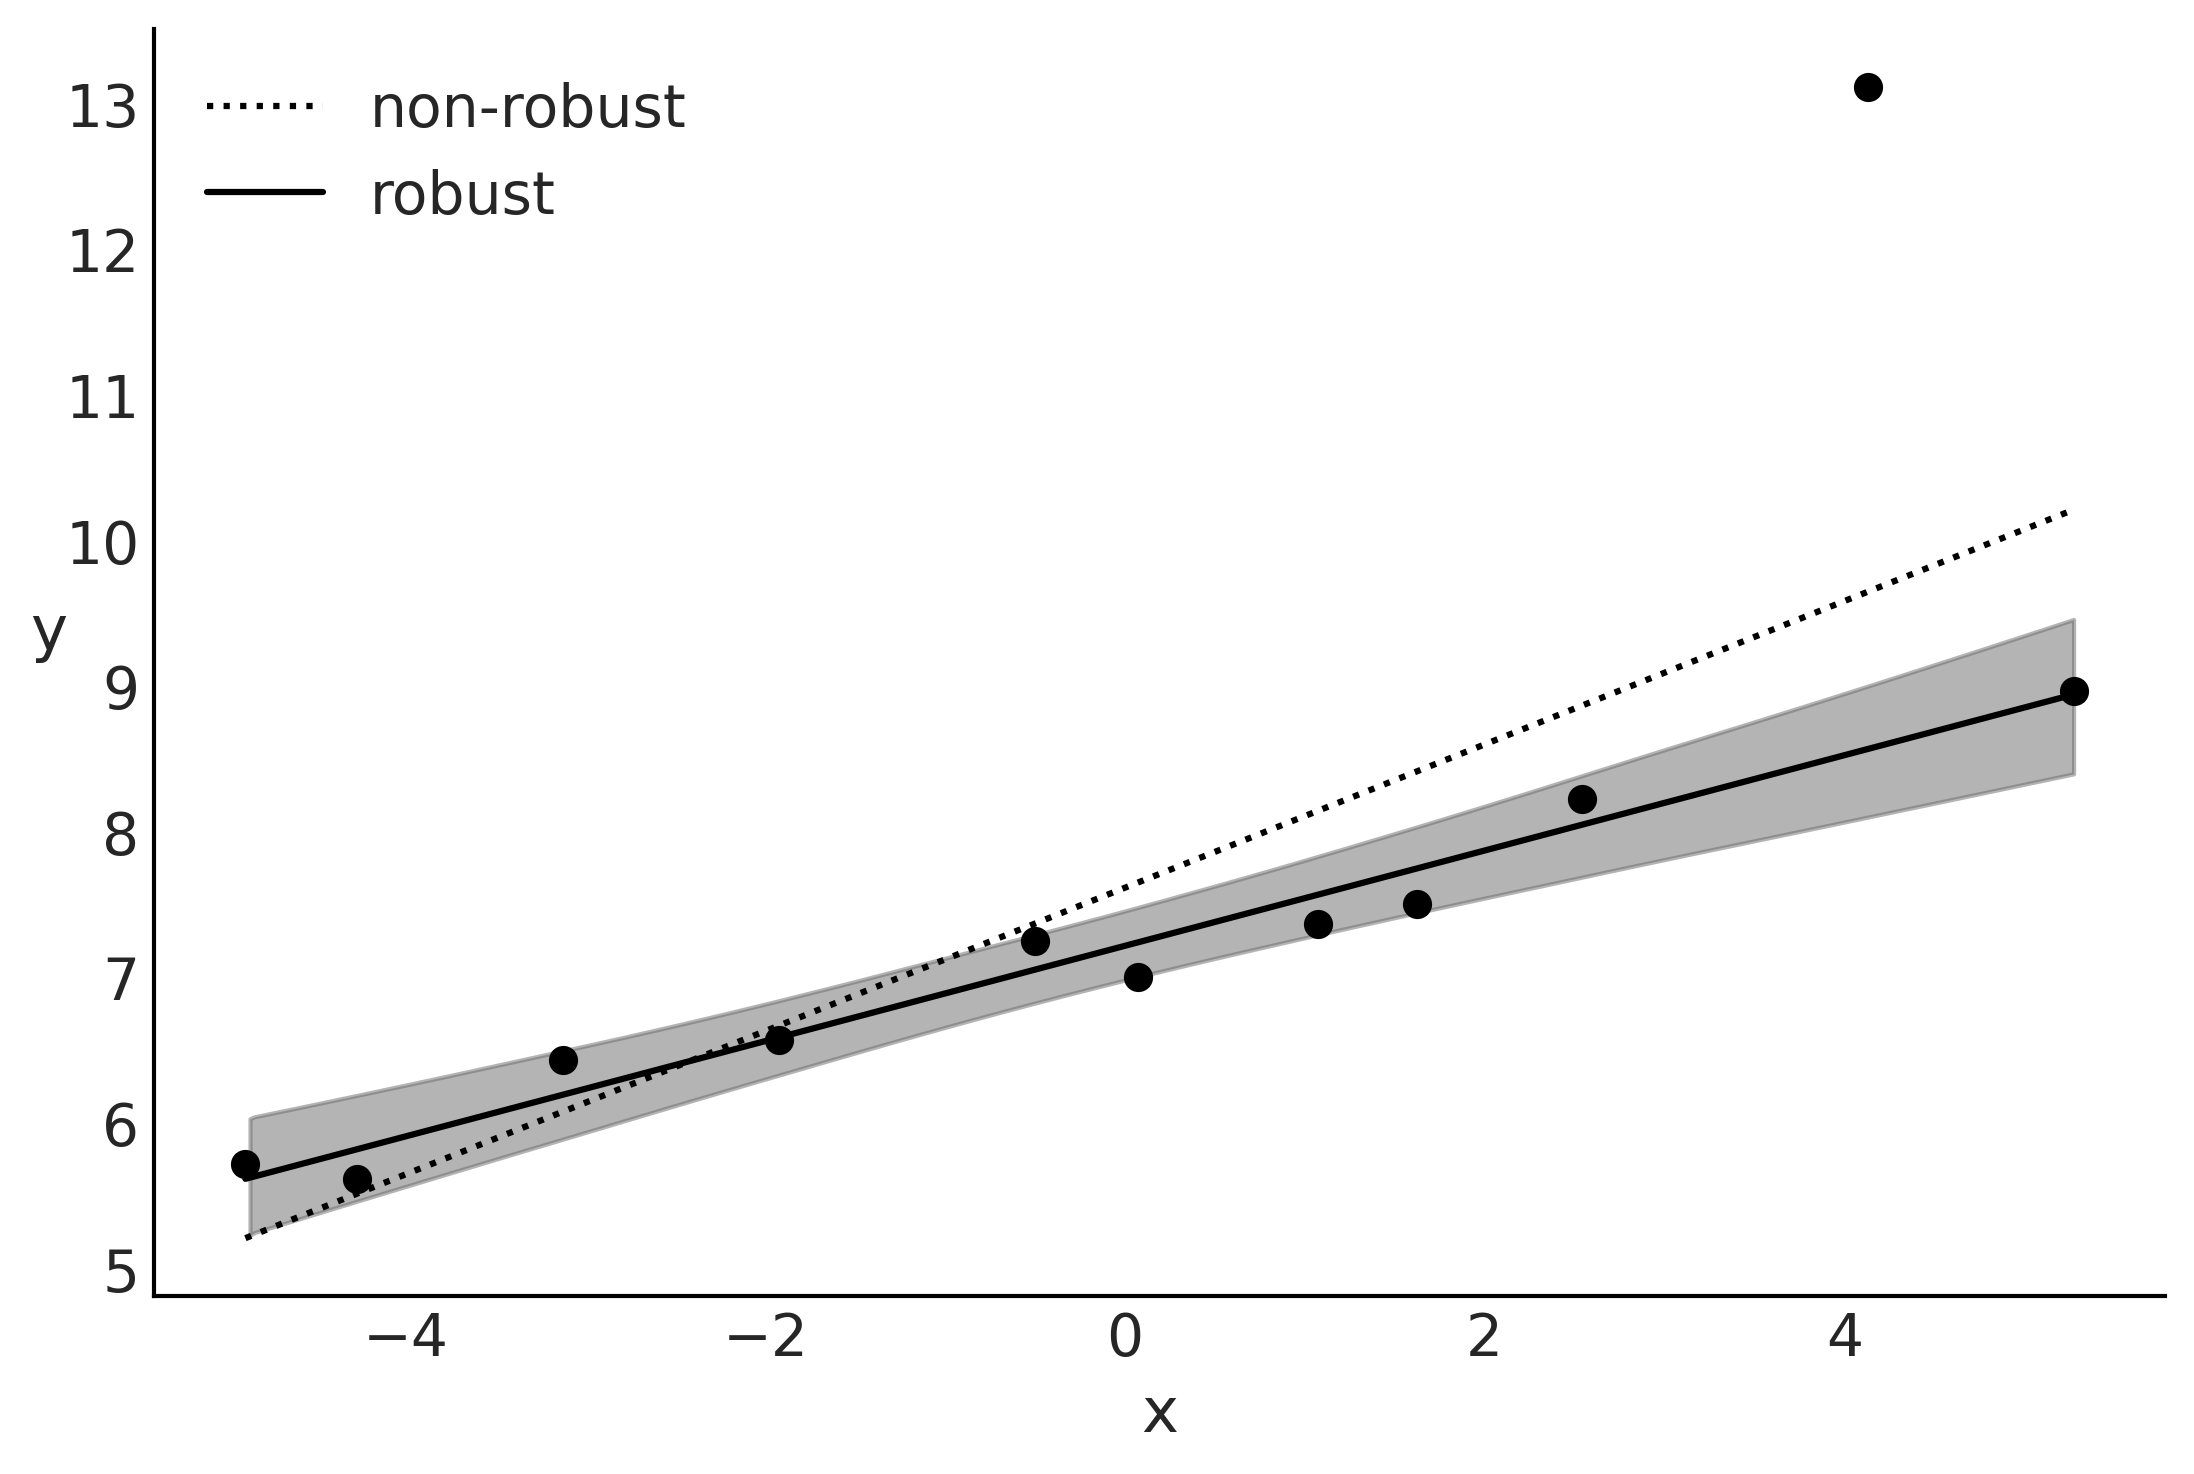

In [17]:
beta_c, alpha_c, *_ = linregress(ans.x, ans.y)

_, ax = plt.subplots()
ax.plot(ans.x, (alpha_c + beta_c * ans.x), "C0:", label="non-robust")
ax.plot(ans.x, ans.y, "C0o")
alpha_m = idata_t.posterior["α"].mean(("chain", "draw"))
beta_m = idata_t.posterior["β"].mean(("chain", "draw"))

x_plot = xr.DataArray(np.linspace(ans.x.min(), ans.x.max(), 50), dims="plot_id")
ax.plot(x_plot, alpha_m + beta_m * x_plot, c="C0", label="robust")
az.plot_hdi(ans.x, az.hdi(idata_t.posterior["μ"])["μ"].T, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
ax.legend(loc=2)
plt.savefig("../fig/linear_robust_regression.png")

In [18]:
az.summary(idata_t, var_names=["~µ"], round_to=2, kind="stats")

/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['µ'] have not been found and will be ignored
  warnings.warn(


mean    sd  hdi_3%  hdi_97%
α      7.21  0.14    6.98     7.45
β      0.33  0.05    0.25     0.40
σ      0.33  0.24    0.09     0.67
ν_     1.77  6.09    0.00     3.49
ν      2.77  6.09    1.00     4.49
μ[0]   5.61  0.23    5.22     6.02
μ[1]   5.82  0.21    5.46     6.19
μ[2]   6.19  0.17    5.88     6.49
μ[3]   6.58  0.14    6.33     6.83
μ[4]   7.05  0.14    6.83     7.29
μ[5]   7.24  0.14    7.00     7.47
μ[6]   7.56  0.16    7.29     7.83
μ[7]   7.74  0.18    7.44     8.02
μ[8]   8.04  0.21    7.69     8.38
μ[9]   8.57  0.27    8.10     8.99
μ[10]  8.94  0.32    8.39     9.45

Sampling: [y_pred]


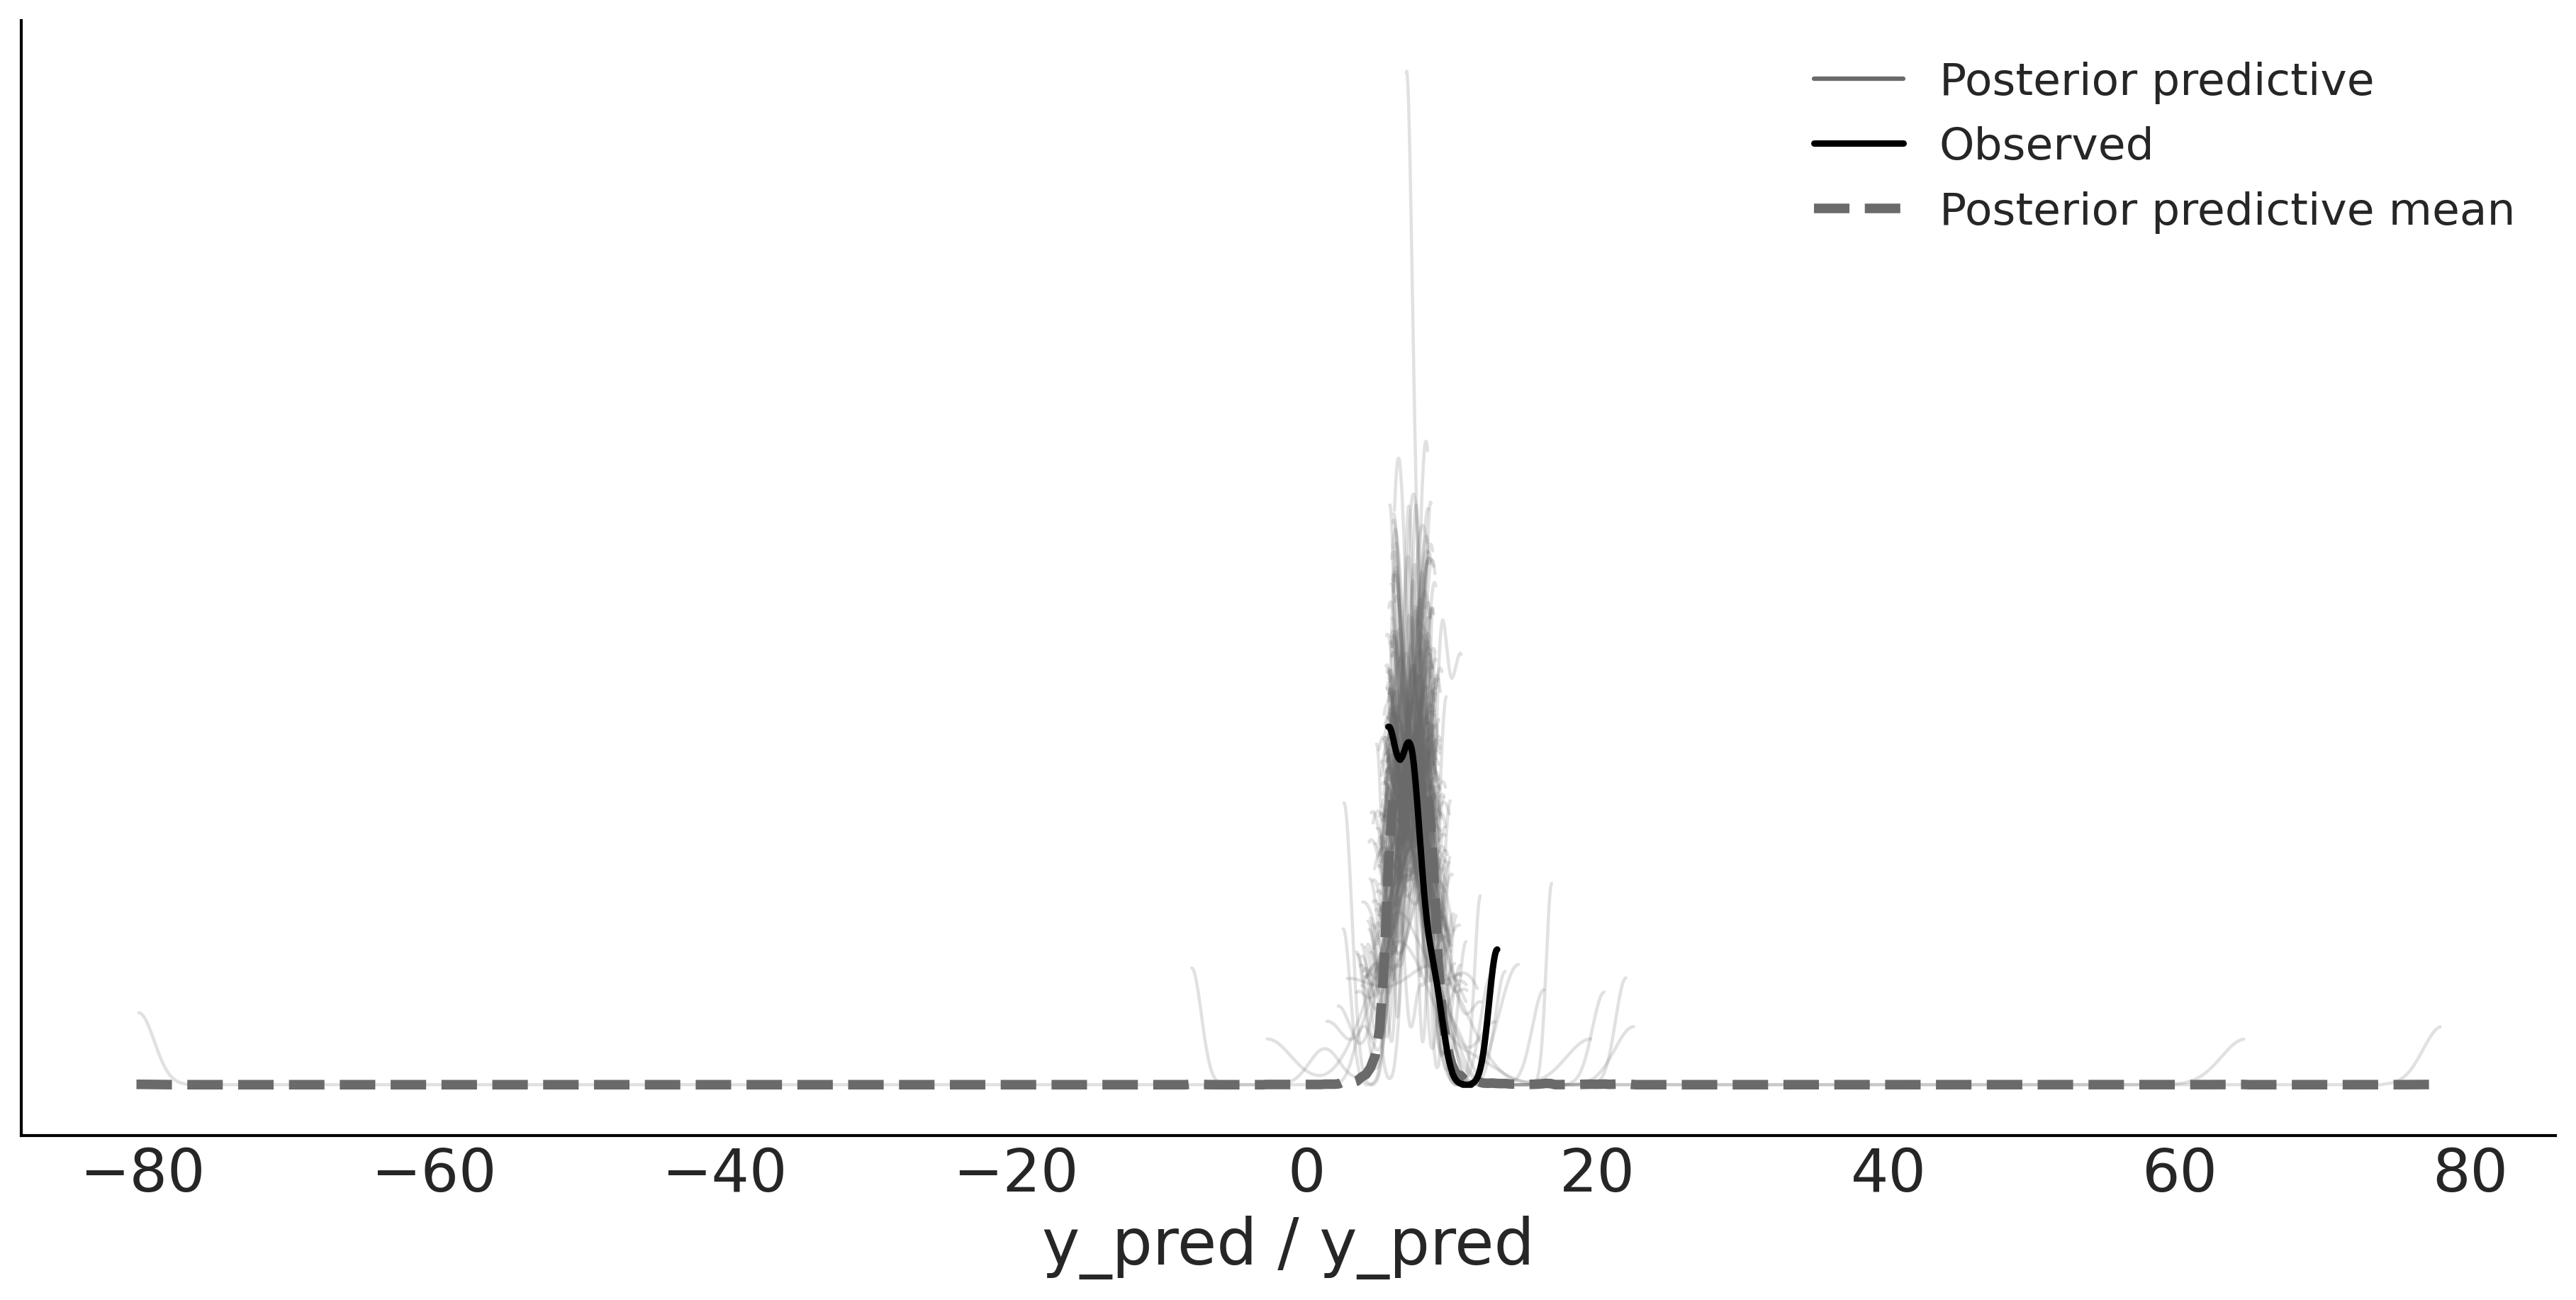

In [19]:
# fmt: off
pm.sample_posterior_predictive(idata_t, model=model_t, random_seed=2, extend_inferencedata=True)
ax = az.plot_ppc(idata_t, num_pp_samples=200, figsize=(12, 6), colors=["C1", "C0", "C1"])
plt.savefig("../fig/linear_robust_regression_ppc.png")

## Logistic regression

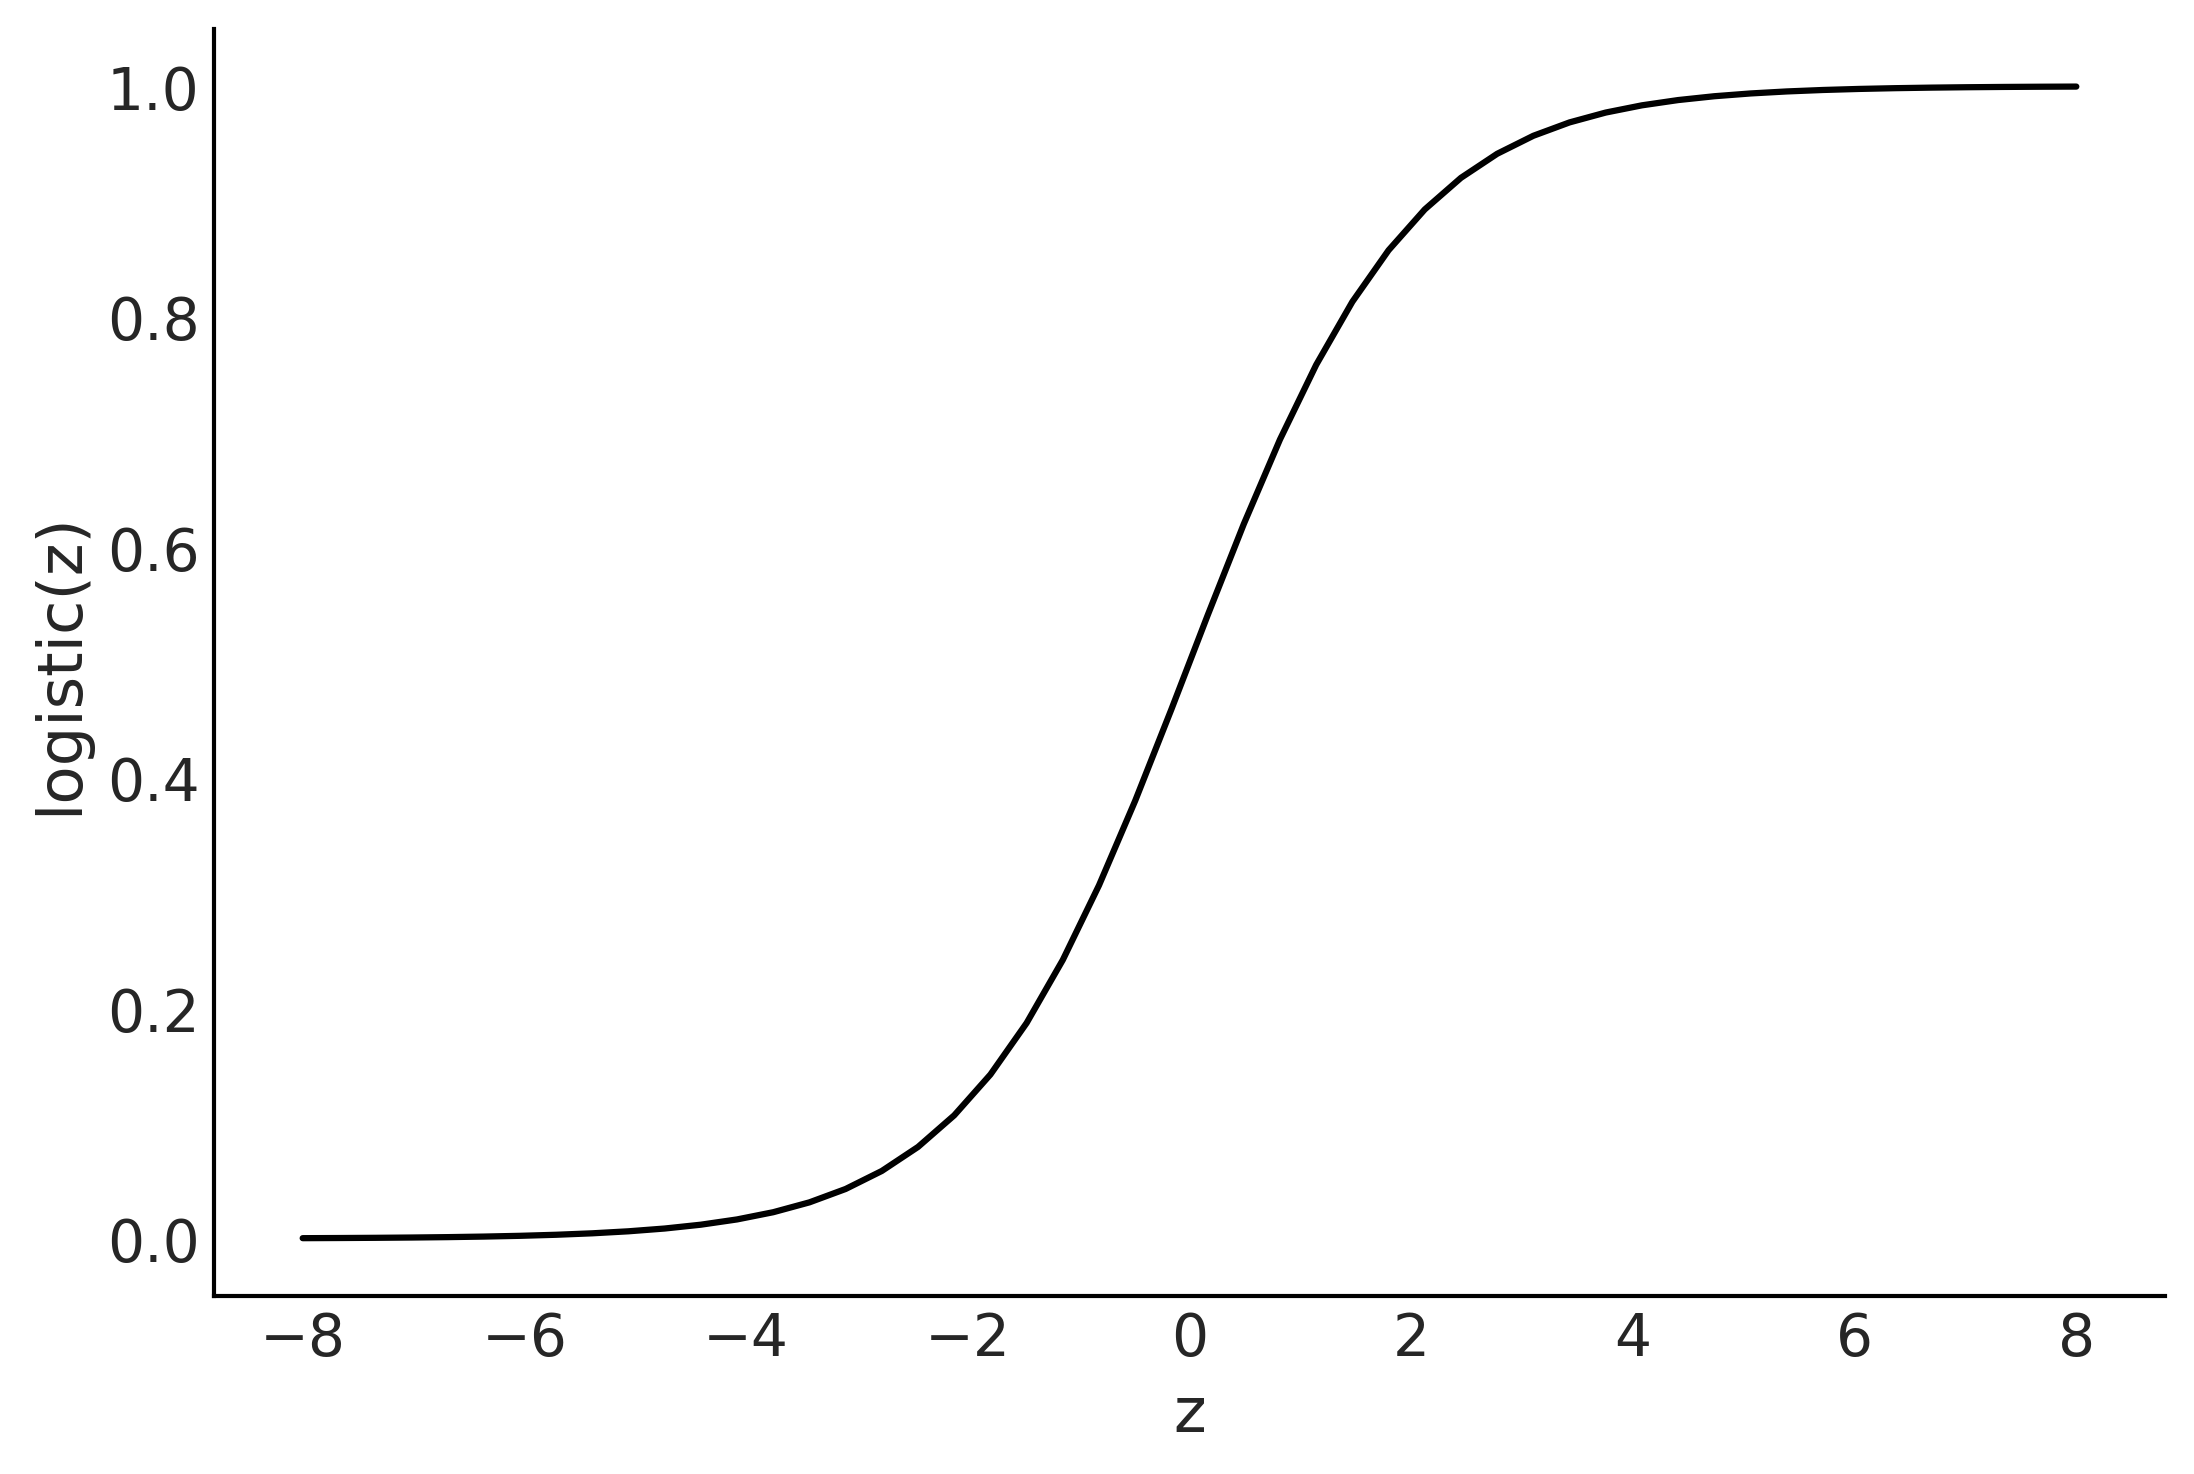

In [20]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel("z")
plt.ylabel("logistic(z)")
plt.savefig("../fig/logistic.png")

In [21]:
iris = pd.read_csv("data/iris.csv")
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [22]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df["species"]).codes
x_n = "sepal_length"
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [23]:
with pm.Model() as model_lrs:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=5)
    μ = α + x_c * β
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -α / β)
    yl = pm.Bernoulli("yl", p=θ, observed=y_0)
    idata_lrs = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


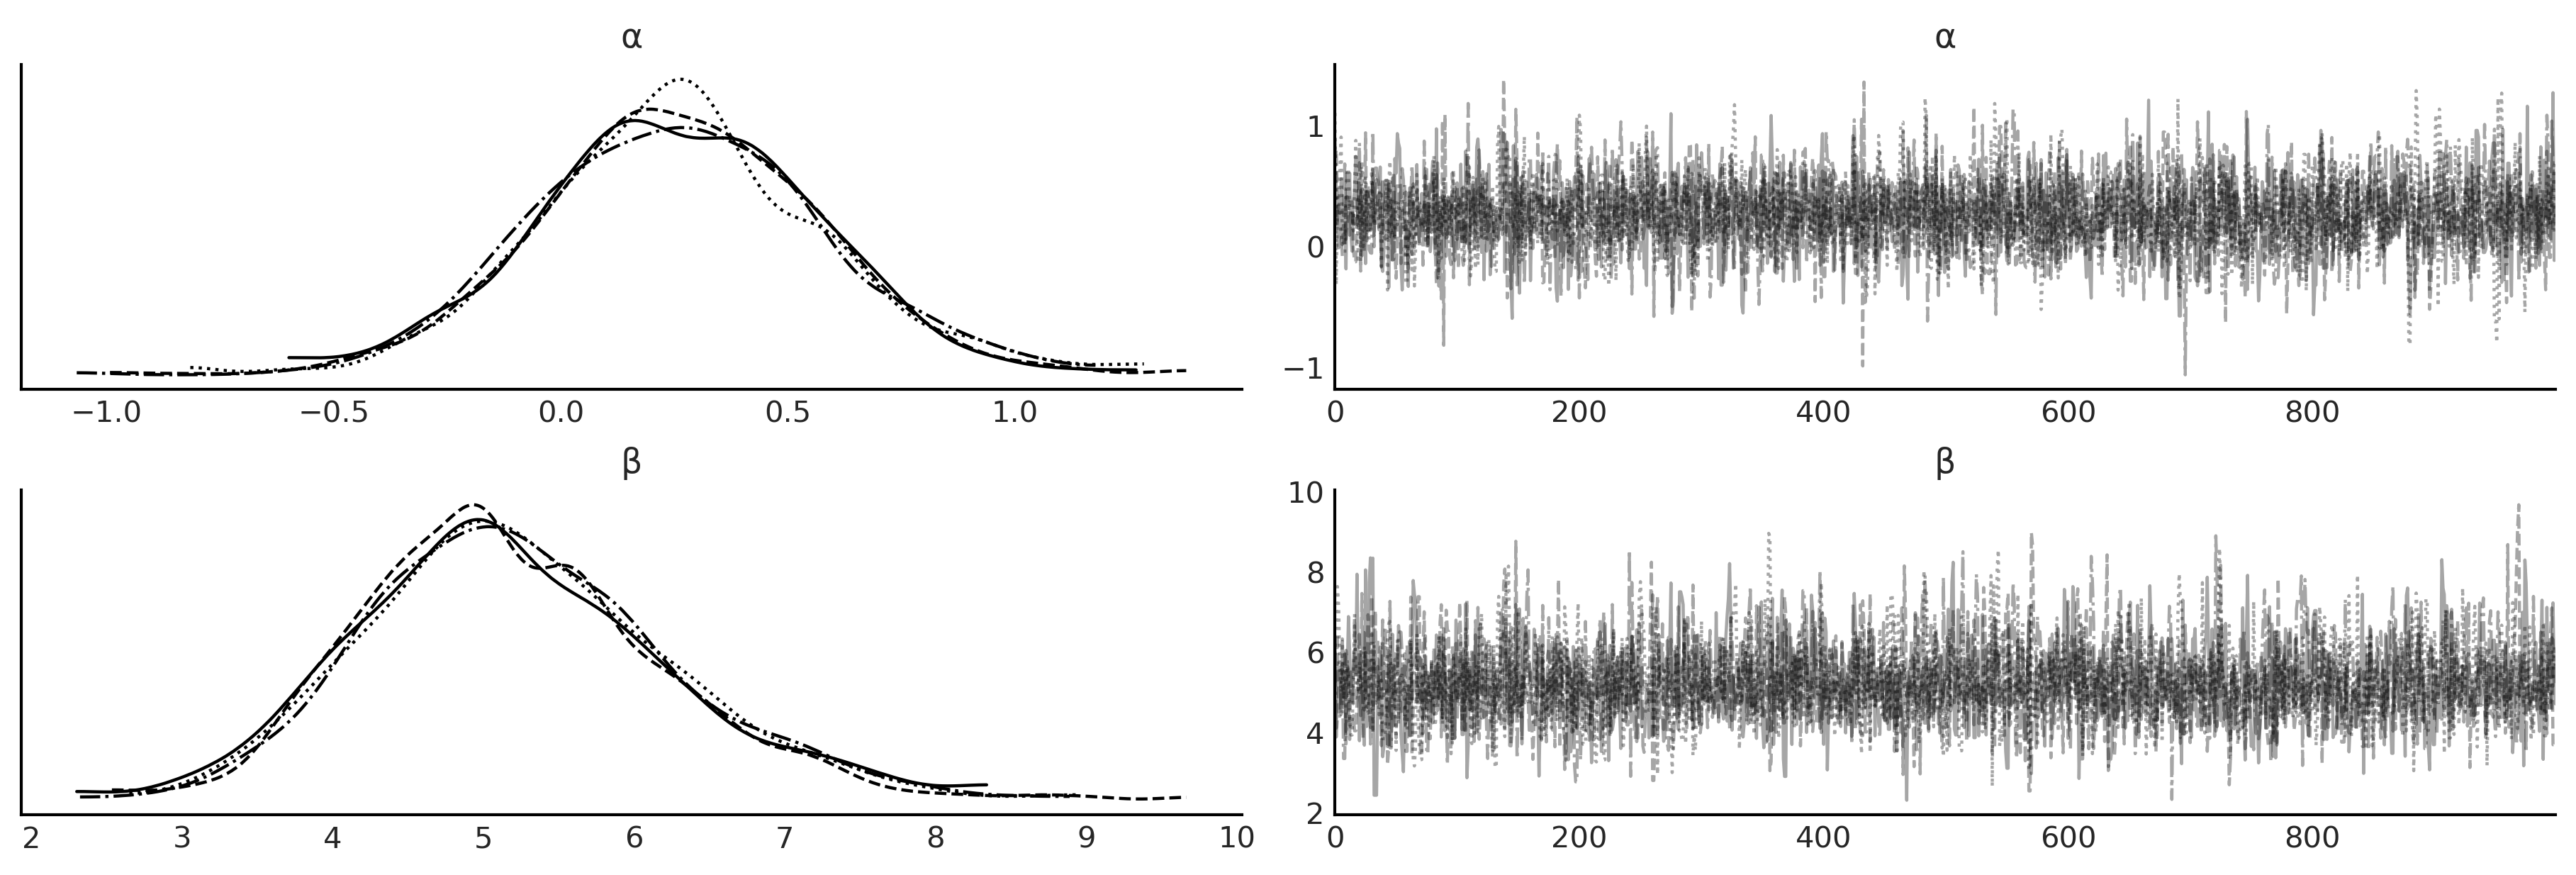

In [24]:
az.plot_trace(idata_lrs, var_names=["~bd", "~θ"]);

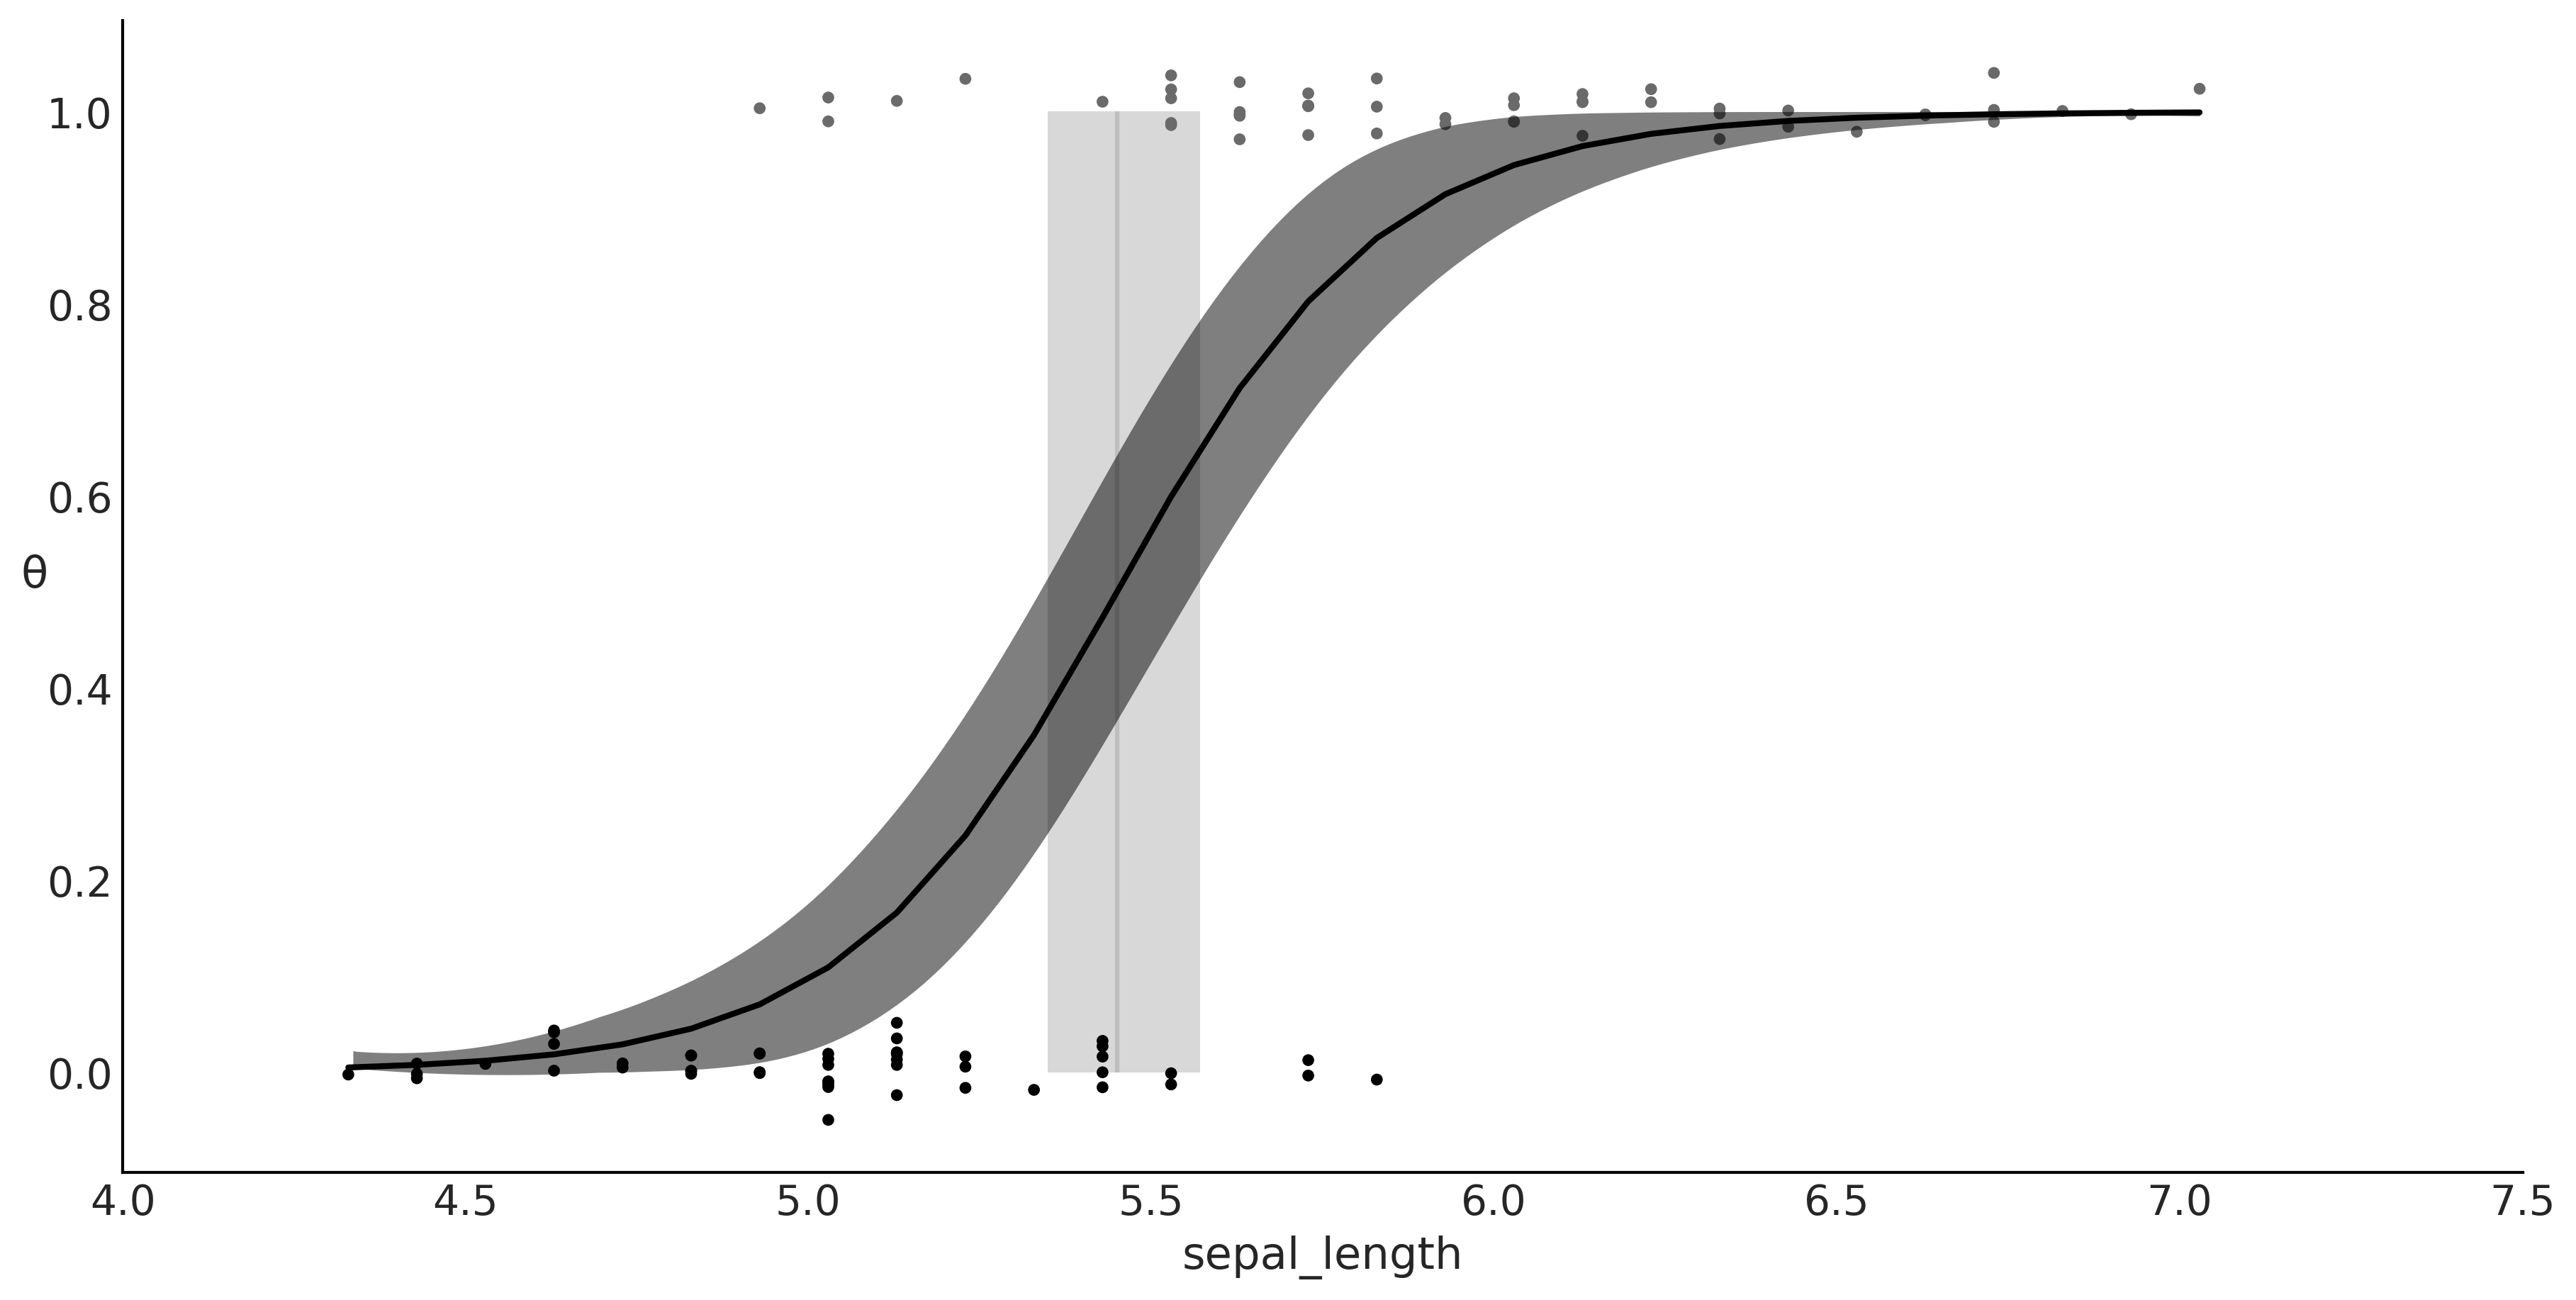

In [25]:
posterior = idata_lrs.posterior
theta = posterior["θ"].mean(("chain", "draw"))
idx = np.argsort(x_c)

_, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_c[idx], theta[idx], color="C0", lw=2)
ax.vlines(posterior["bd"].mean(("chain", "draw")), 0, 1, color="C2", zorder=0)
bd_hdi = az.hdi(posterior["bd"])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color="C2", alpha=0.6, lw=0)
ax.scatter(x_c, np.random.normal(y_0, 0.02), marker=".", color=[f"C{x}" for x in y_0])
az.plot_hdi(x_c, posterior["θ"], color="C0", ax=ax, fill_kwargs={"lw": 0})
ax.set_xlabel(x_n)
ax.set_ylabel("θ", rotation=0)
# # use original scale for xticks
locs, _ = plt.xticks()
ax.set_xticks(locs, np.round(locs + x_0.mean(), 1))
plt.savefig("../fig/logistic_regression.png")

/tmp/ipykernel_28521/115630748.py:2: RuntimeWarning: divide by zero encountered in divide
  odds = probability / (1 - probability)


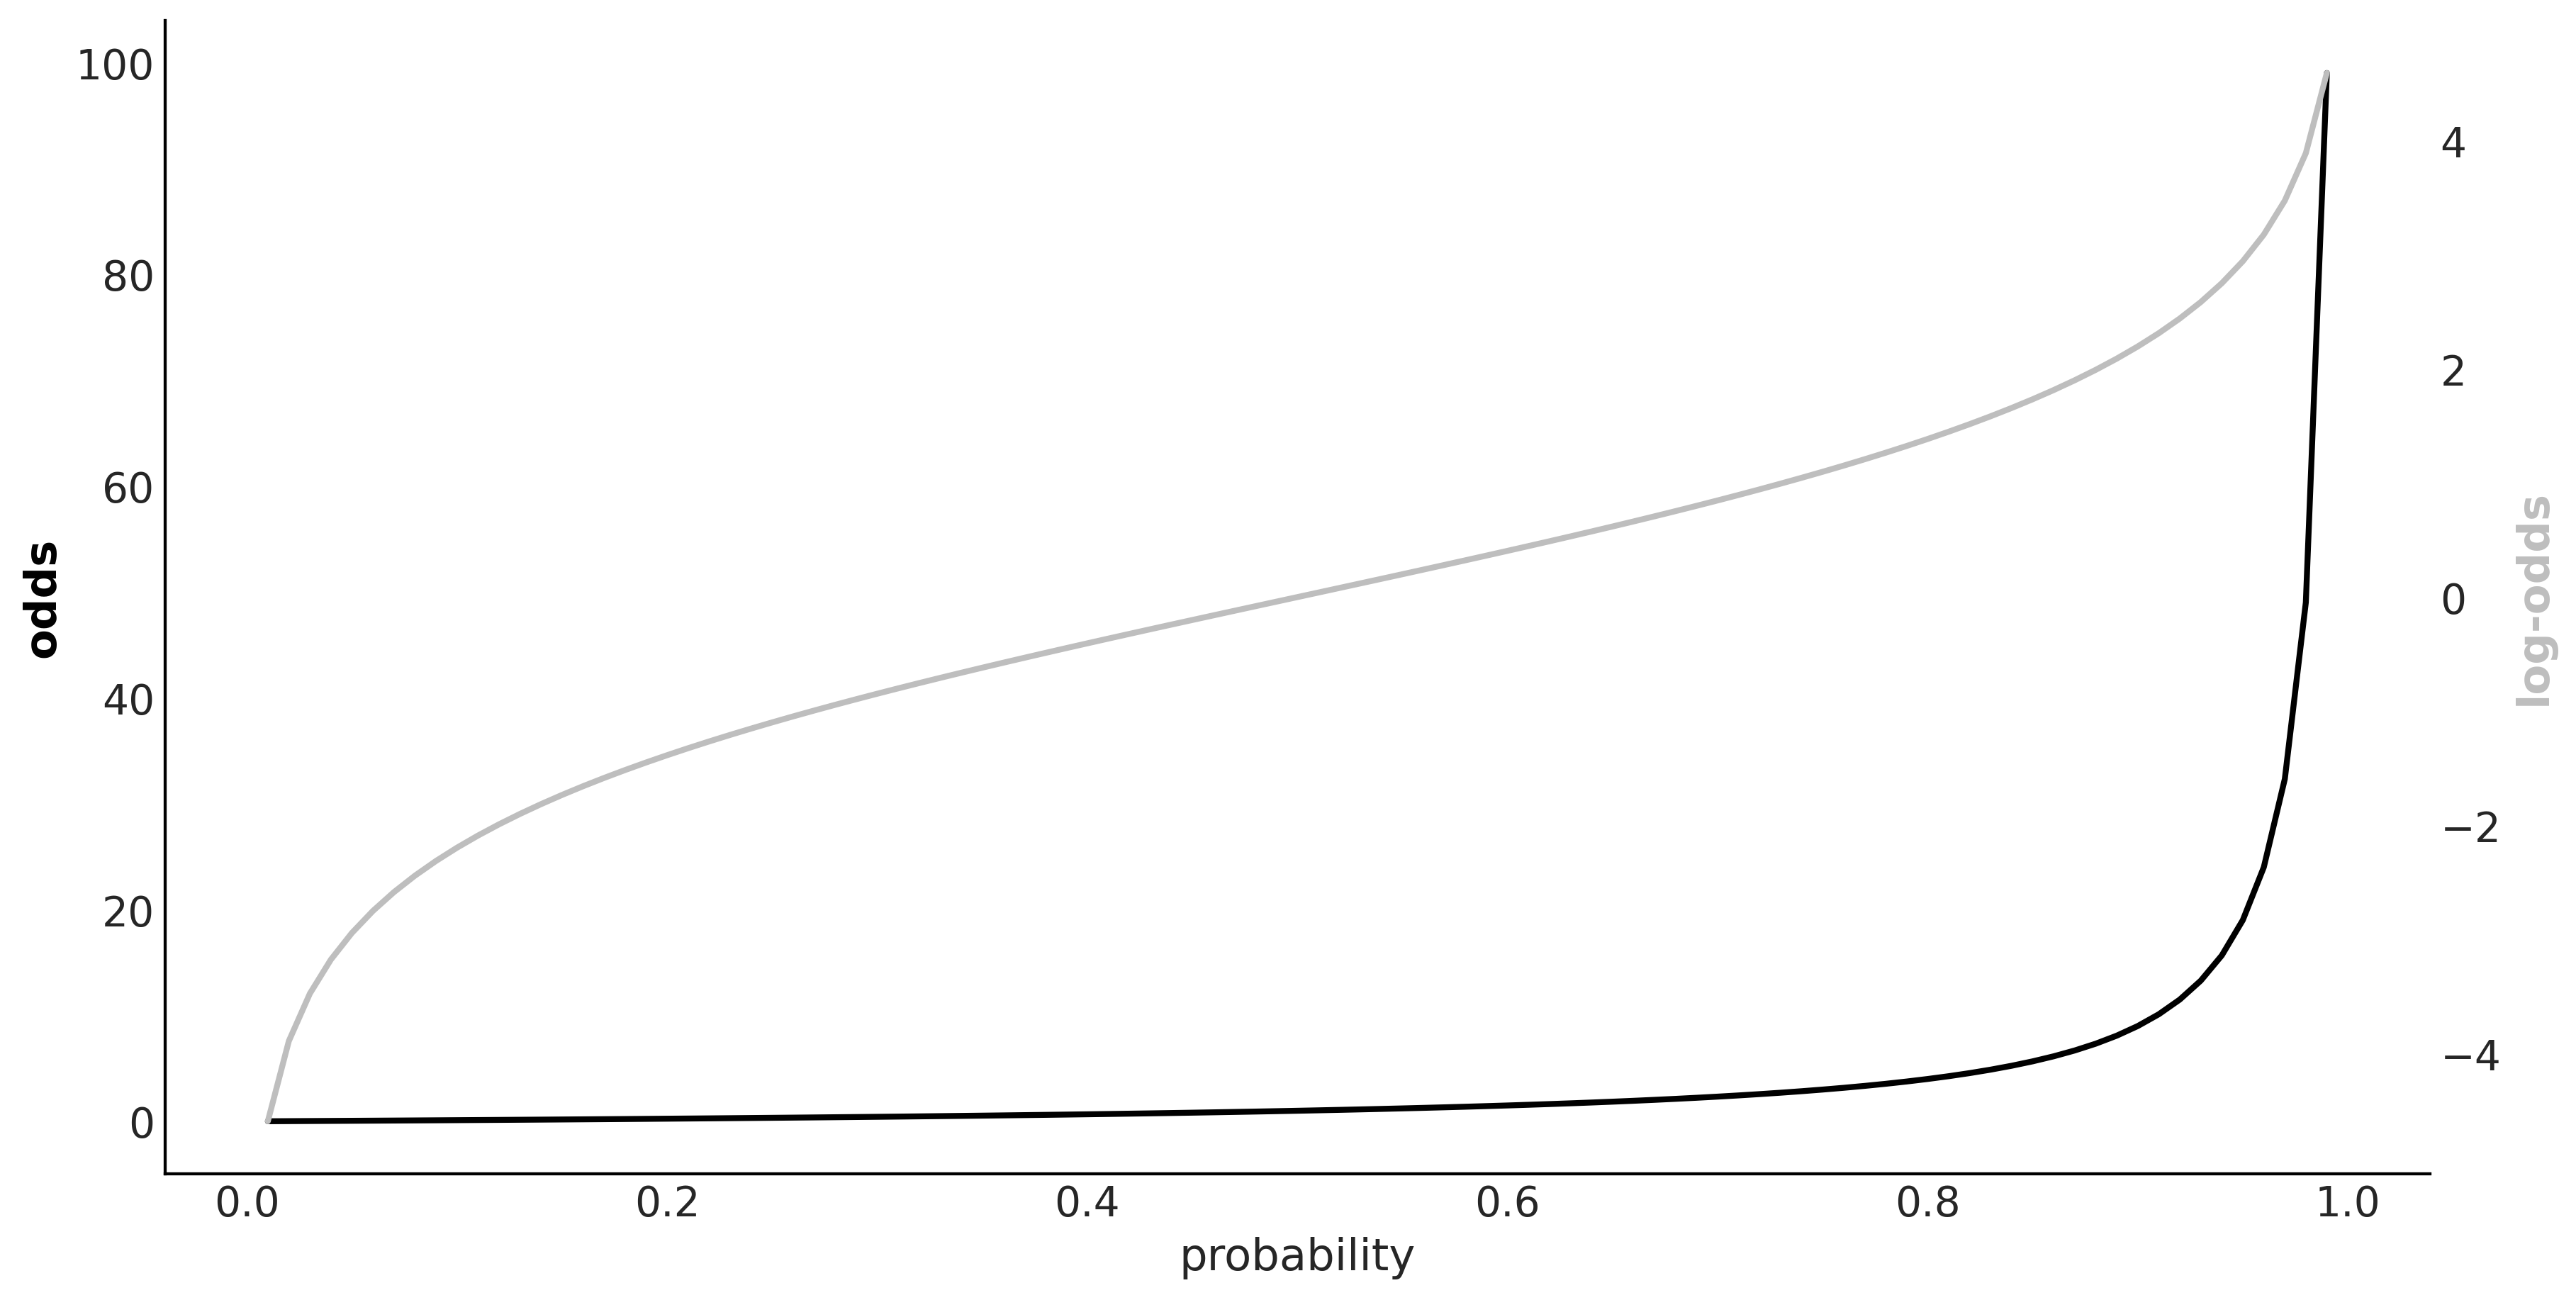

In [26]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)
_, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(probability, odds, "C0", lw=2)
ax2.plot(probability, np.log(odds), "C2", lw=2)
ax1.set_xlabel("probability")
ax1.set_ylabel("odds", color="C0", fontweight="bold")
ax2.set_ylabel("log-odds", color="C2", fontweight="bold")
ax1.grid(False)
ax2.grid(False)
plt.savefig("../fig/logistic_odds.png")

## Variable Variance

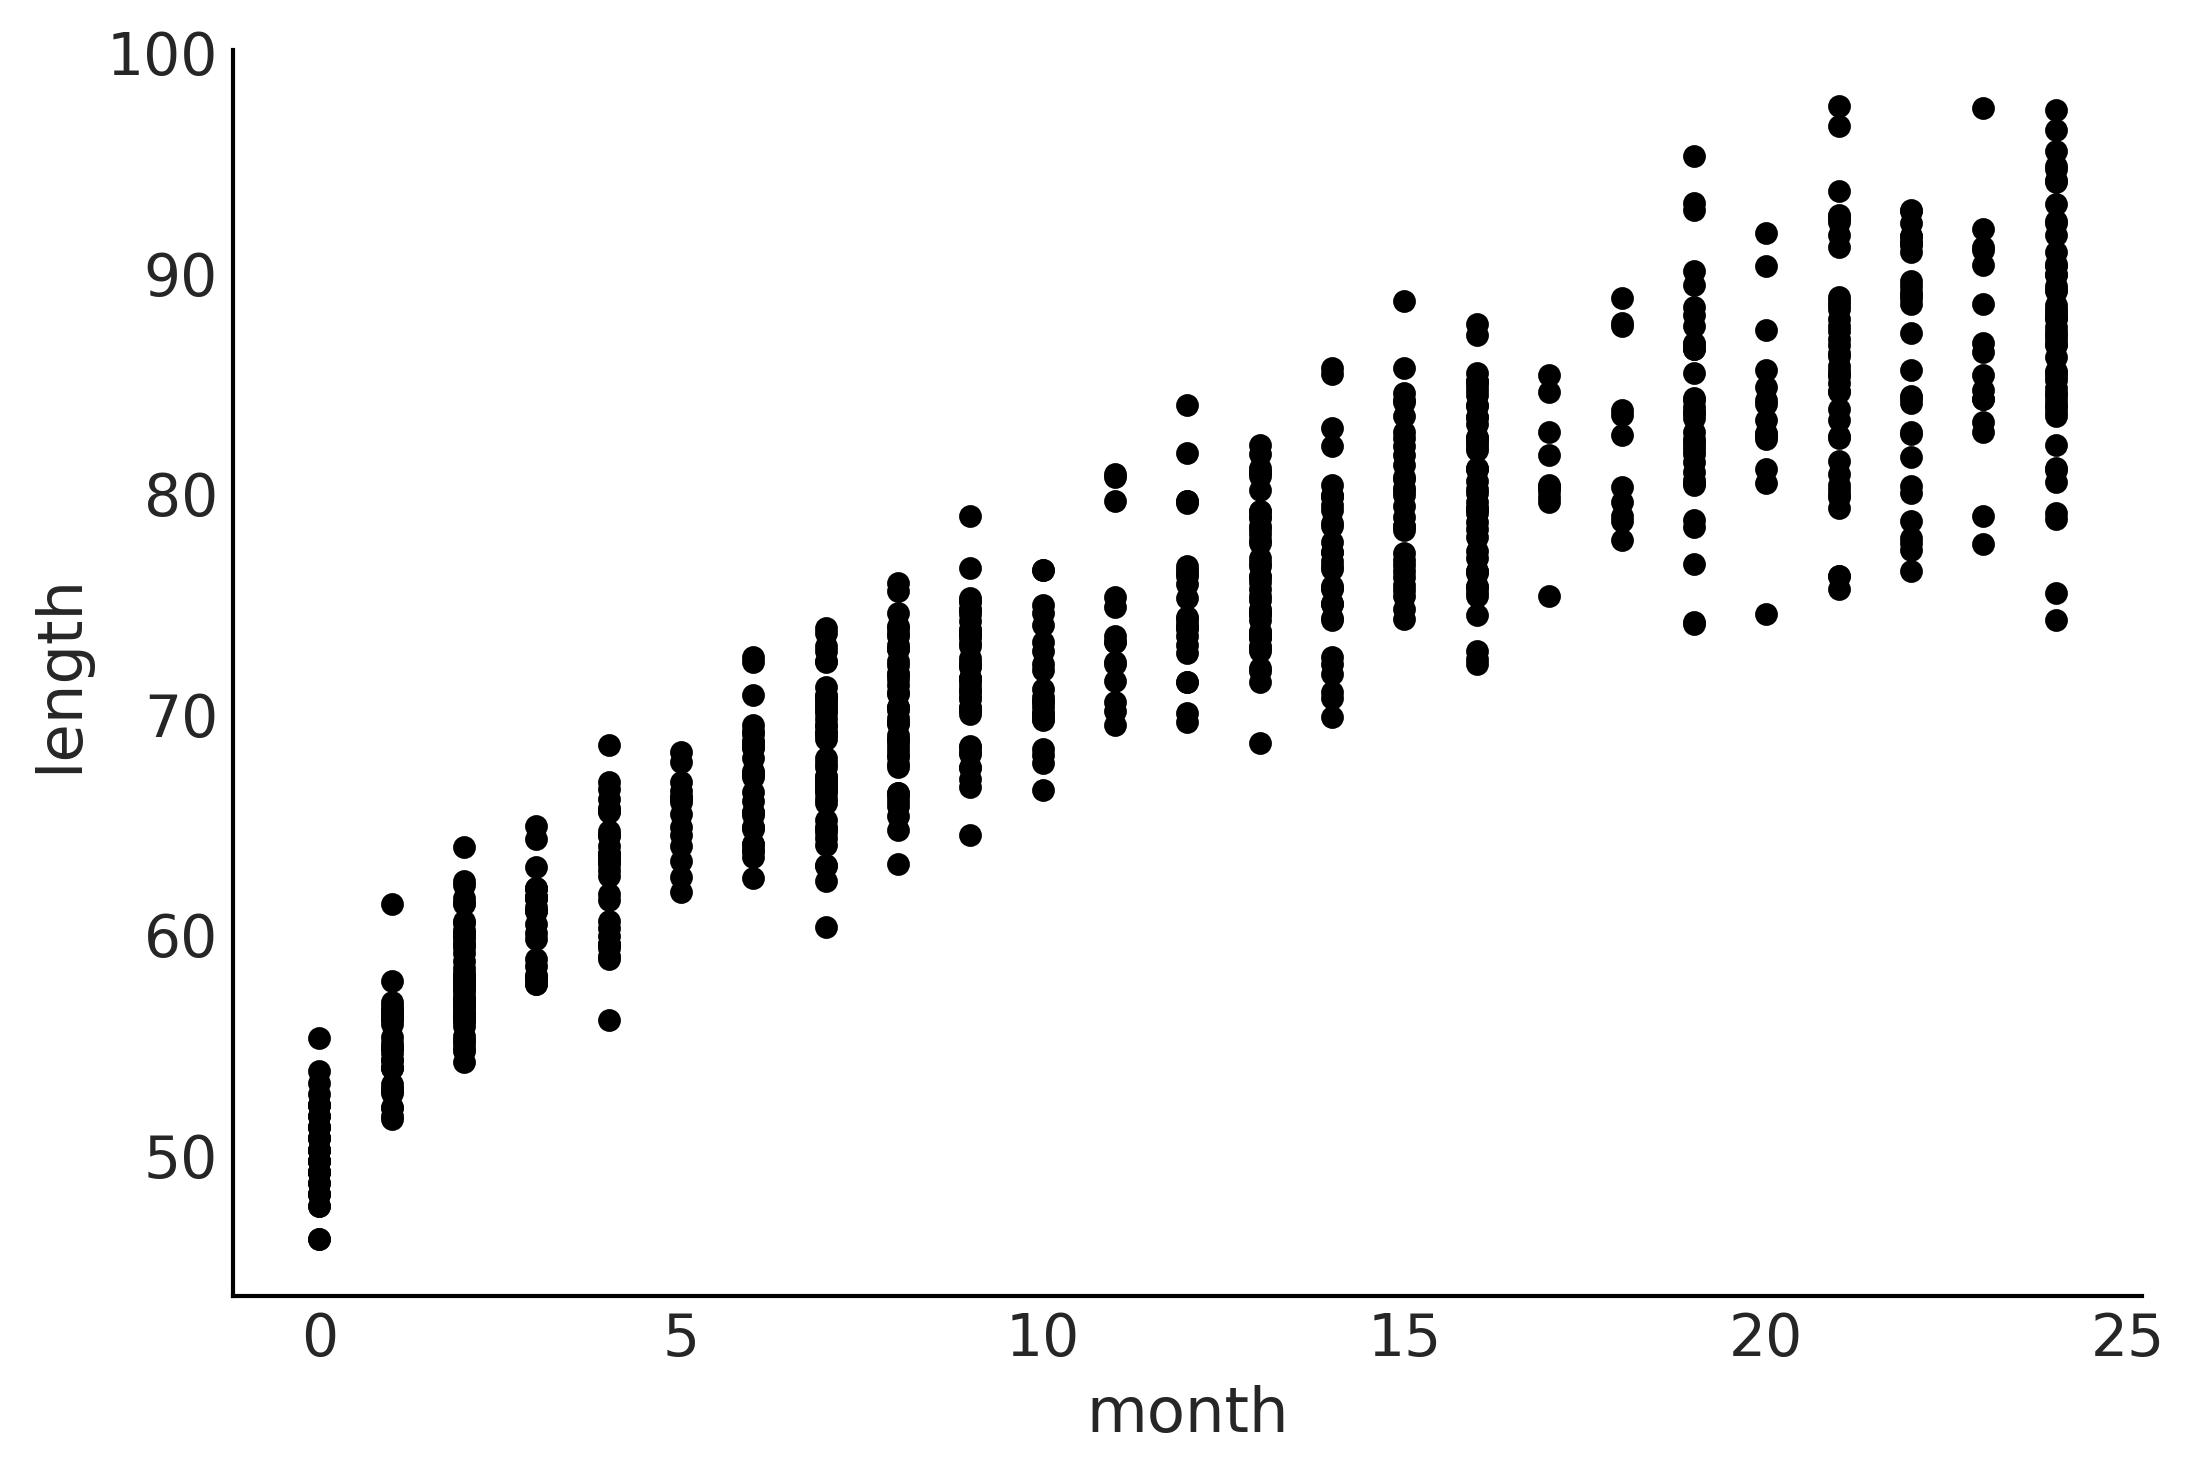

In [27]:
data = pd.read_csv("data/babies.csv")
data.plot.scatter("month", "length");

In [28]:
with pm.Model() as model_vv:
    x_shared = pm.MutableData("x_shared", data.month.values.astype(float))
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    μ = pm.Deterministic("μ", α + β * x_shared**0.5)
    σ = pm.Deterministic("σ", γ + δ * x_shared)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.length)

    idata_vv = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


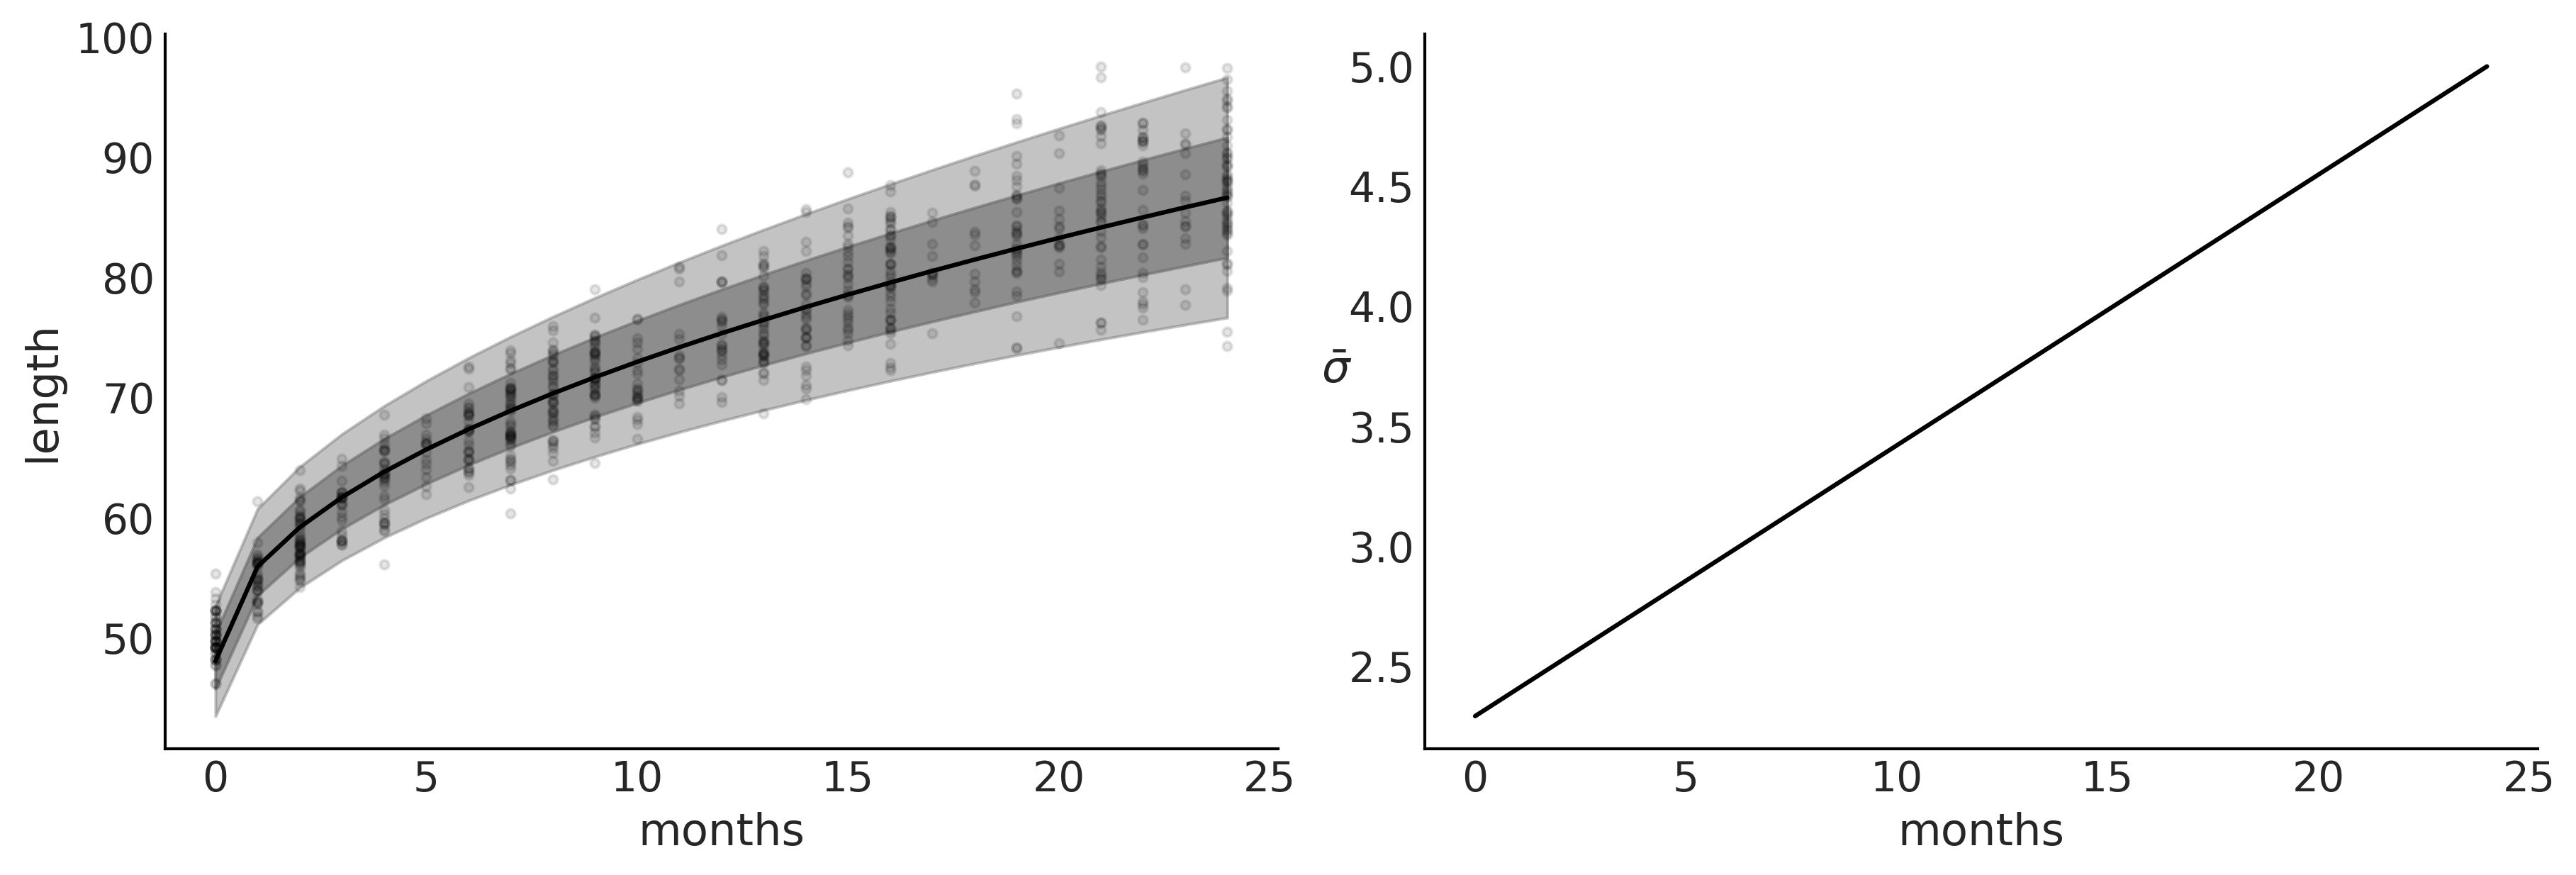

In [29]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(data.month, data.length, "C0.", alpha=0.1)

posterior = az.extract(idata_vv)

μ_m = posterior["μ"].mean("sample").values
σ_m = posterior["σ"].mean("sample").values

axes[0].plot(data.month, μ_m, c="k")
axes[0].fill_between(data.month, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
axes[0].fill_between(data.month, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

axes[0].set_xlabel("months")
axes[0].set_ylabel("length")


axes[1].plot(data.month, σ_m)
axes[1].set_xlabel("months")
axes[1].set_ylabel(r"$\bar \sigma$", rotation=0)
plt.savefig("../fig/babies_fit.png")

In [30]:
with model_vv:
    pm.set_data({"x_shared": [0.5]})
    ppc = pm.sample_posterior_predictive(idata_vv)
    y_ppc = ppc.posterior_predictive["y_pred"].stack(sample=("chain", "draw"))

Sampling: [y_pred]


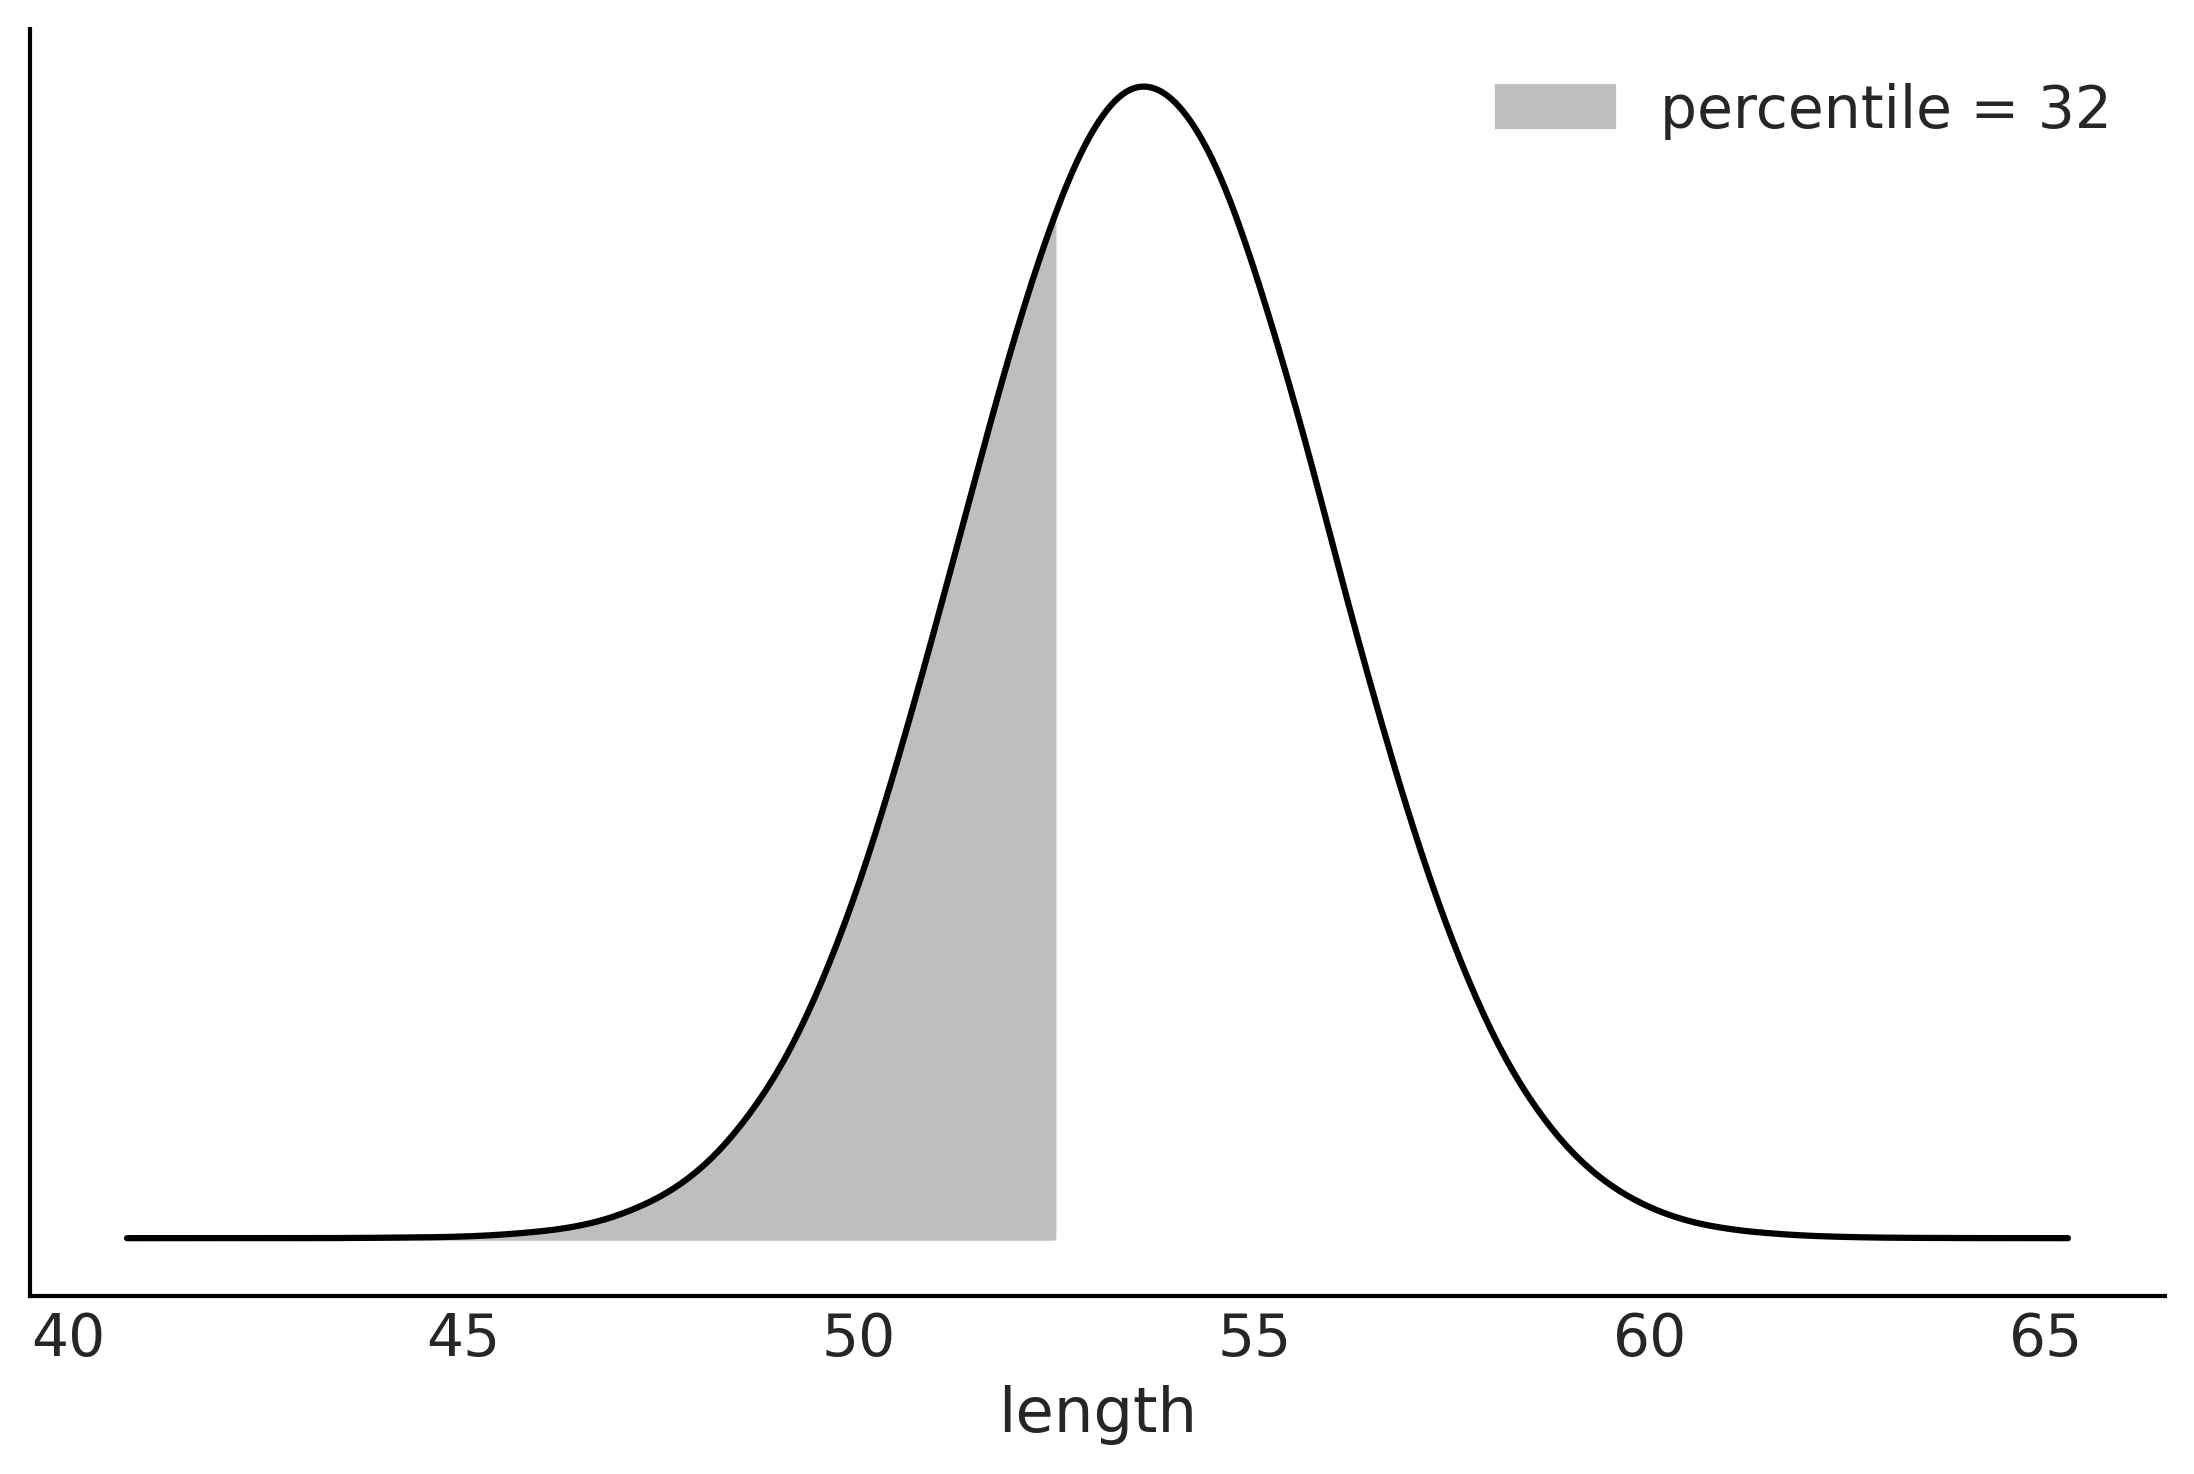

In [31]:
ref = 52.5
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc <= ref).mean() * 100)
plt.fill_between(
    grid[grid < ref],
    pdf[grid < ref],
    label="percentile = {:2d}".format(percentile),
    color="C2",
)
plt.xlabel("length")
plt.yticks([])
plt.legend()
plt.savefig("../fig/babies_ppc.png")

## Hierarchical linear regression

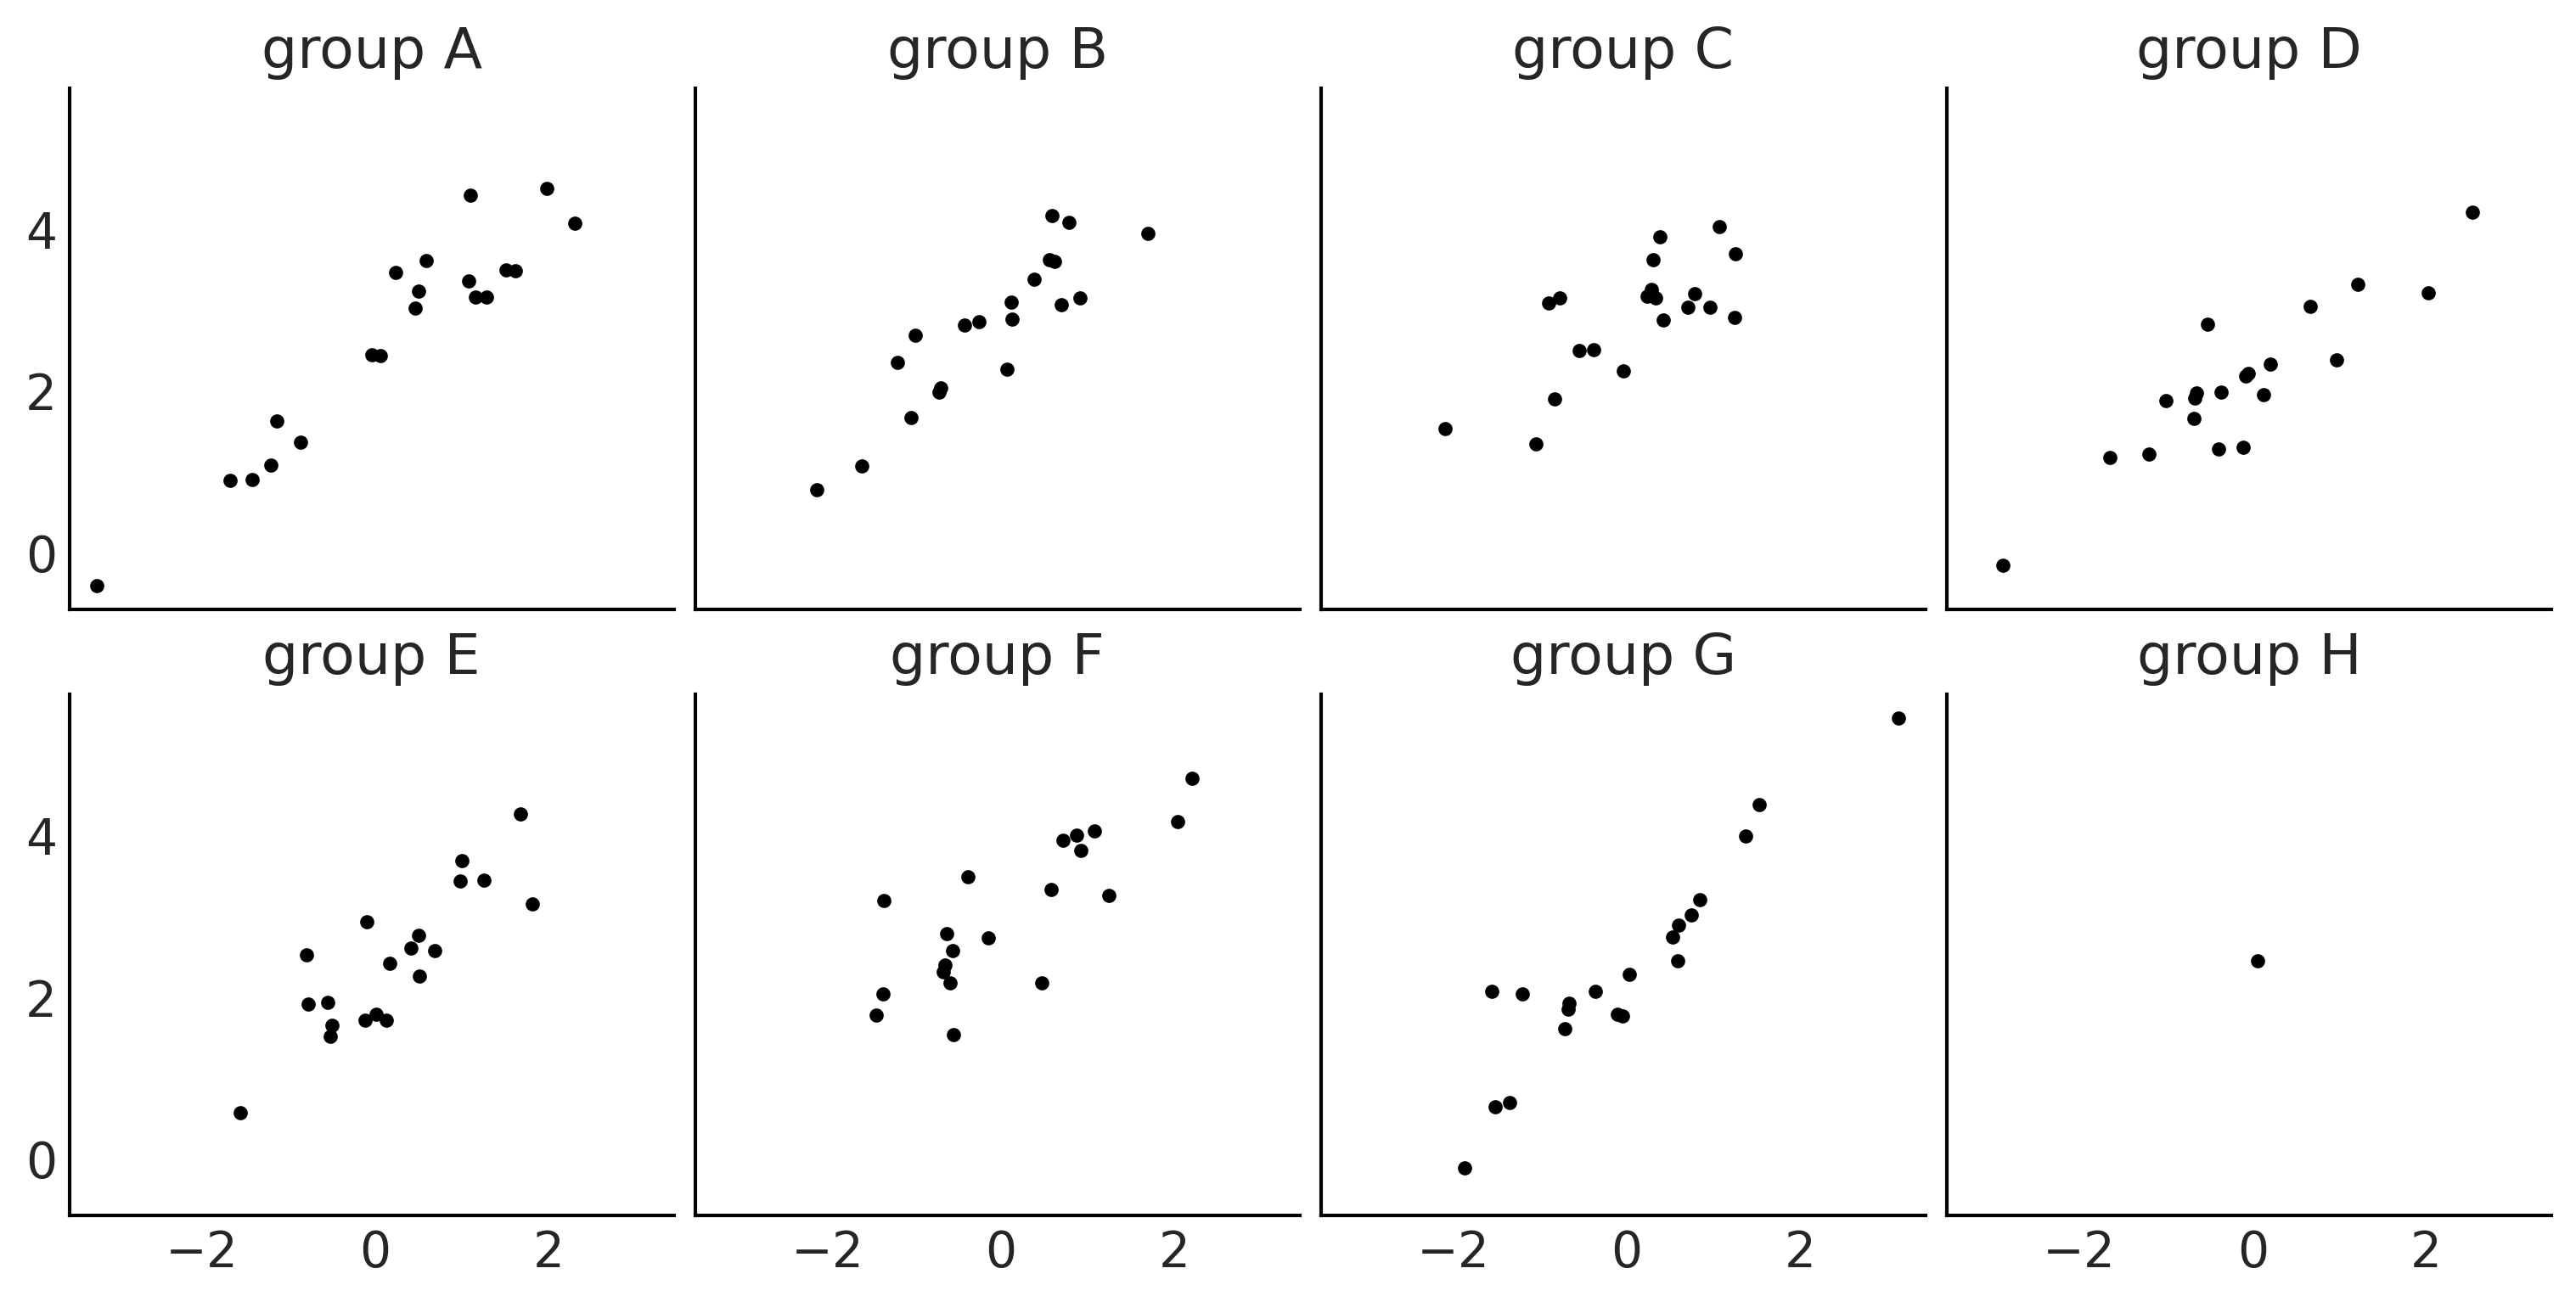

In [32]:
N = 20
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
M = len(groups)
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(0, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_title(f"group {g}")

    j += N
    k += N
plt.savefig("../fig/hierarchical_data.png")

In [33]:

coords = {"group": groups}

with pm.Model(coords=coords) as unpooled_model:
    α = pm.Normal("α", mu=0, sigma=10, dims="group")
    β = pm.Normal("β", mu=0, sigma=10, dims="group")
    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)
    idata_up = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


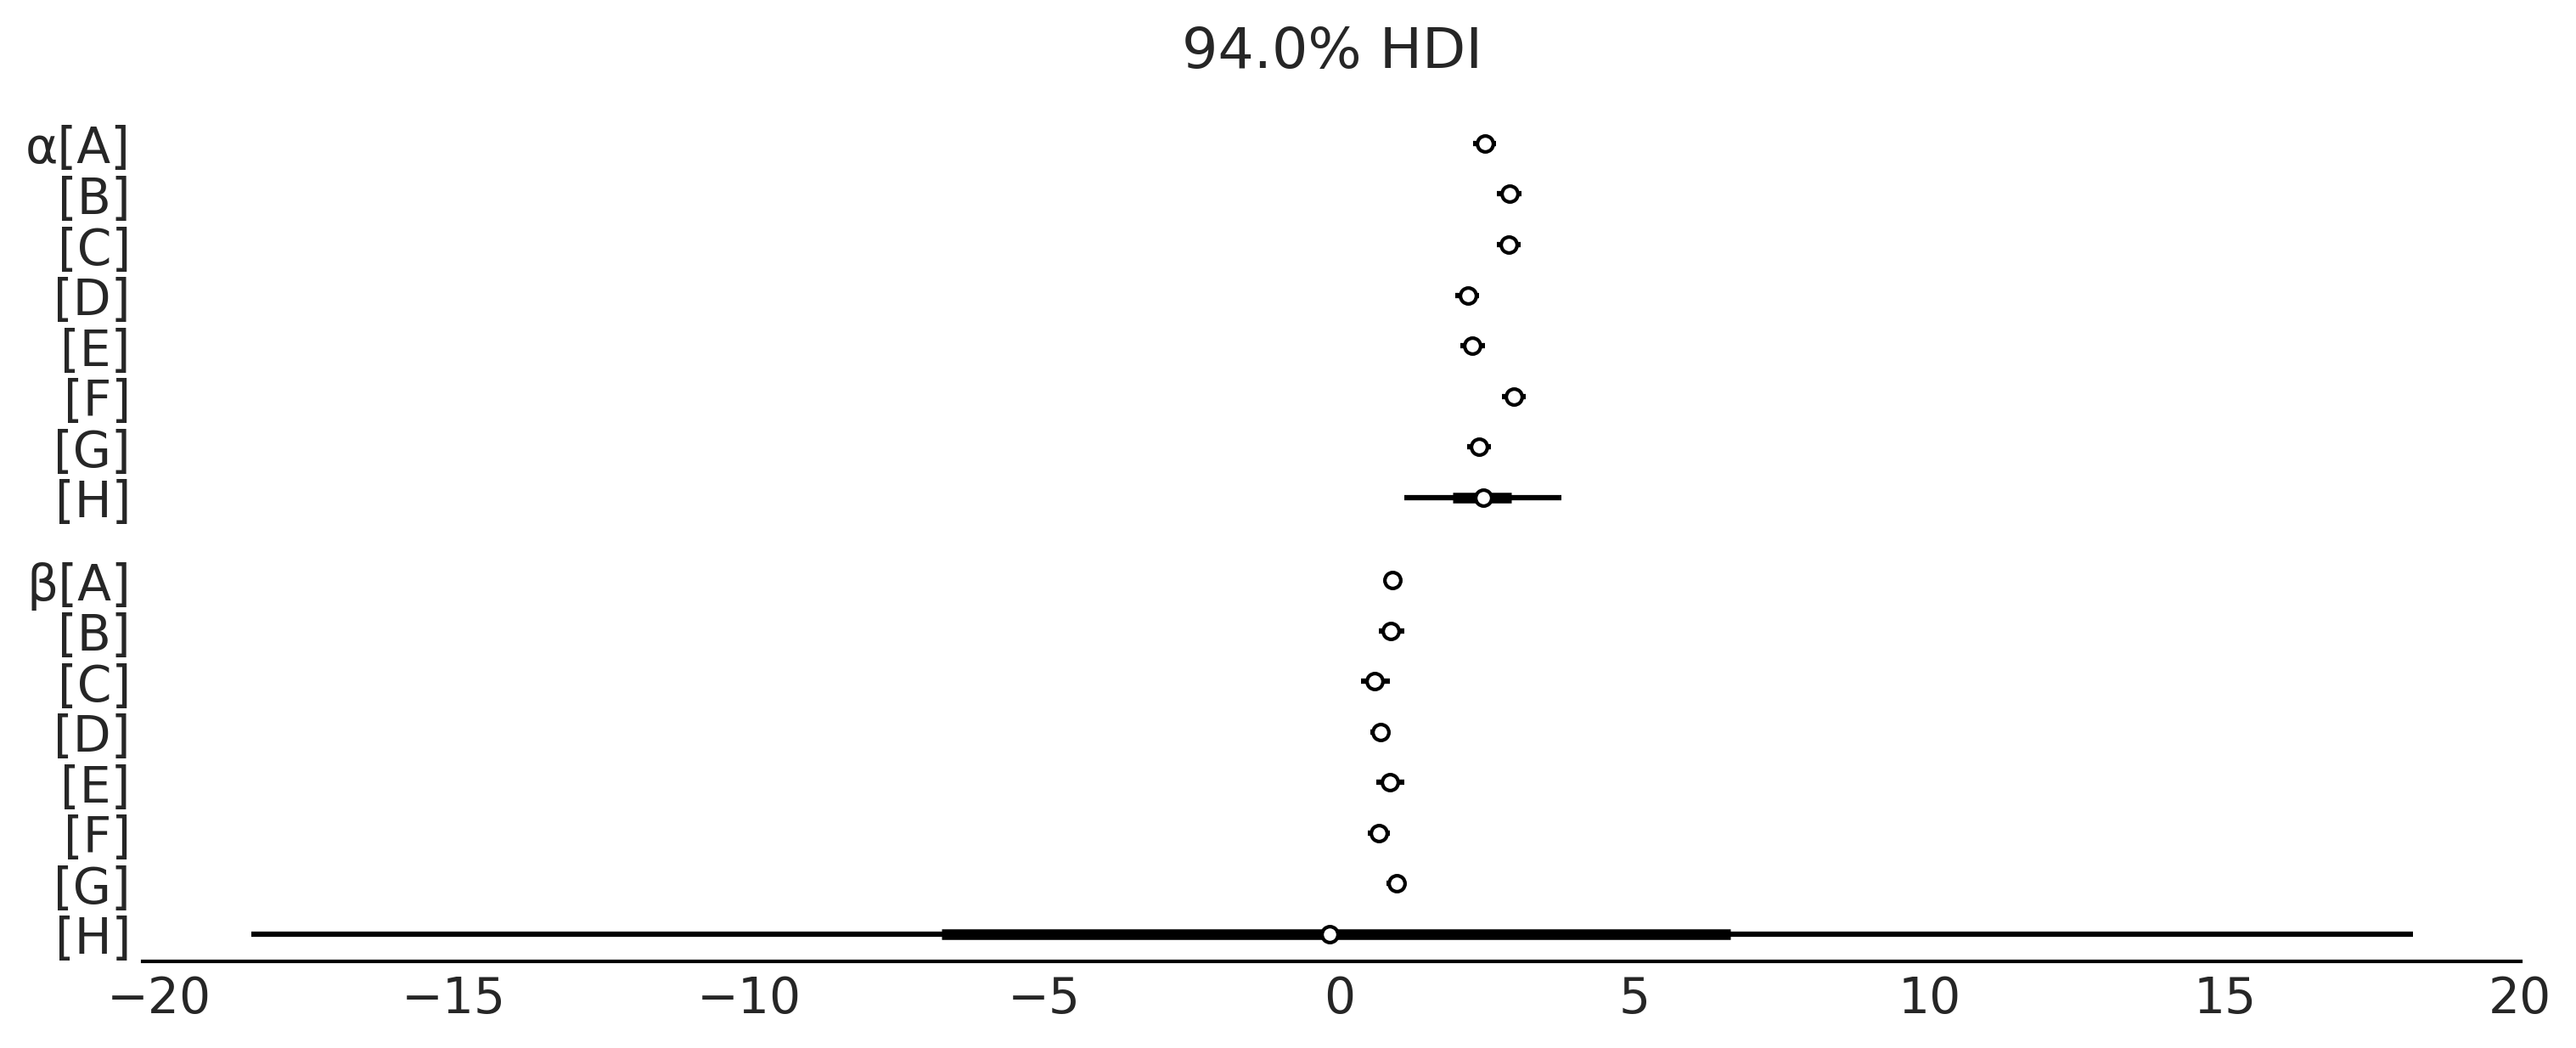

In [34]:
az.plot_forest(idata_up, var_names=["α", "β"], combined=True, figsize=(10, 4))
plt.savefig("../fig/hierarchical_up_forest.png")

In [35]:
with pm.Model(coords=coords) as hierarchical_centered:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="group")
    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_cen = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.


In [36]:
with pm.Model(coords=coords) as hierarchical_non_centered:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group")

    β_offset = pm.Normal("β_offset", mu=0, sigma=1, dims="group")
    β = pm.Deterministic("β", β_μ + β_offset * β_σ, dims="group")

    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_ncen = pm.sample(random_seed=123, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β_offset, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


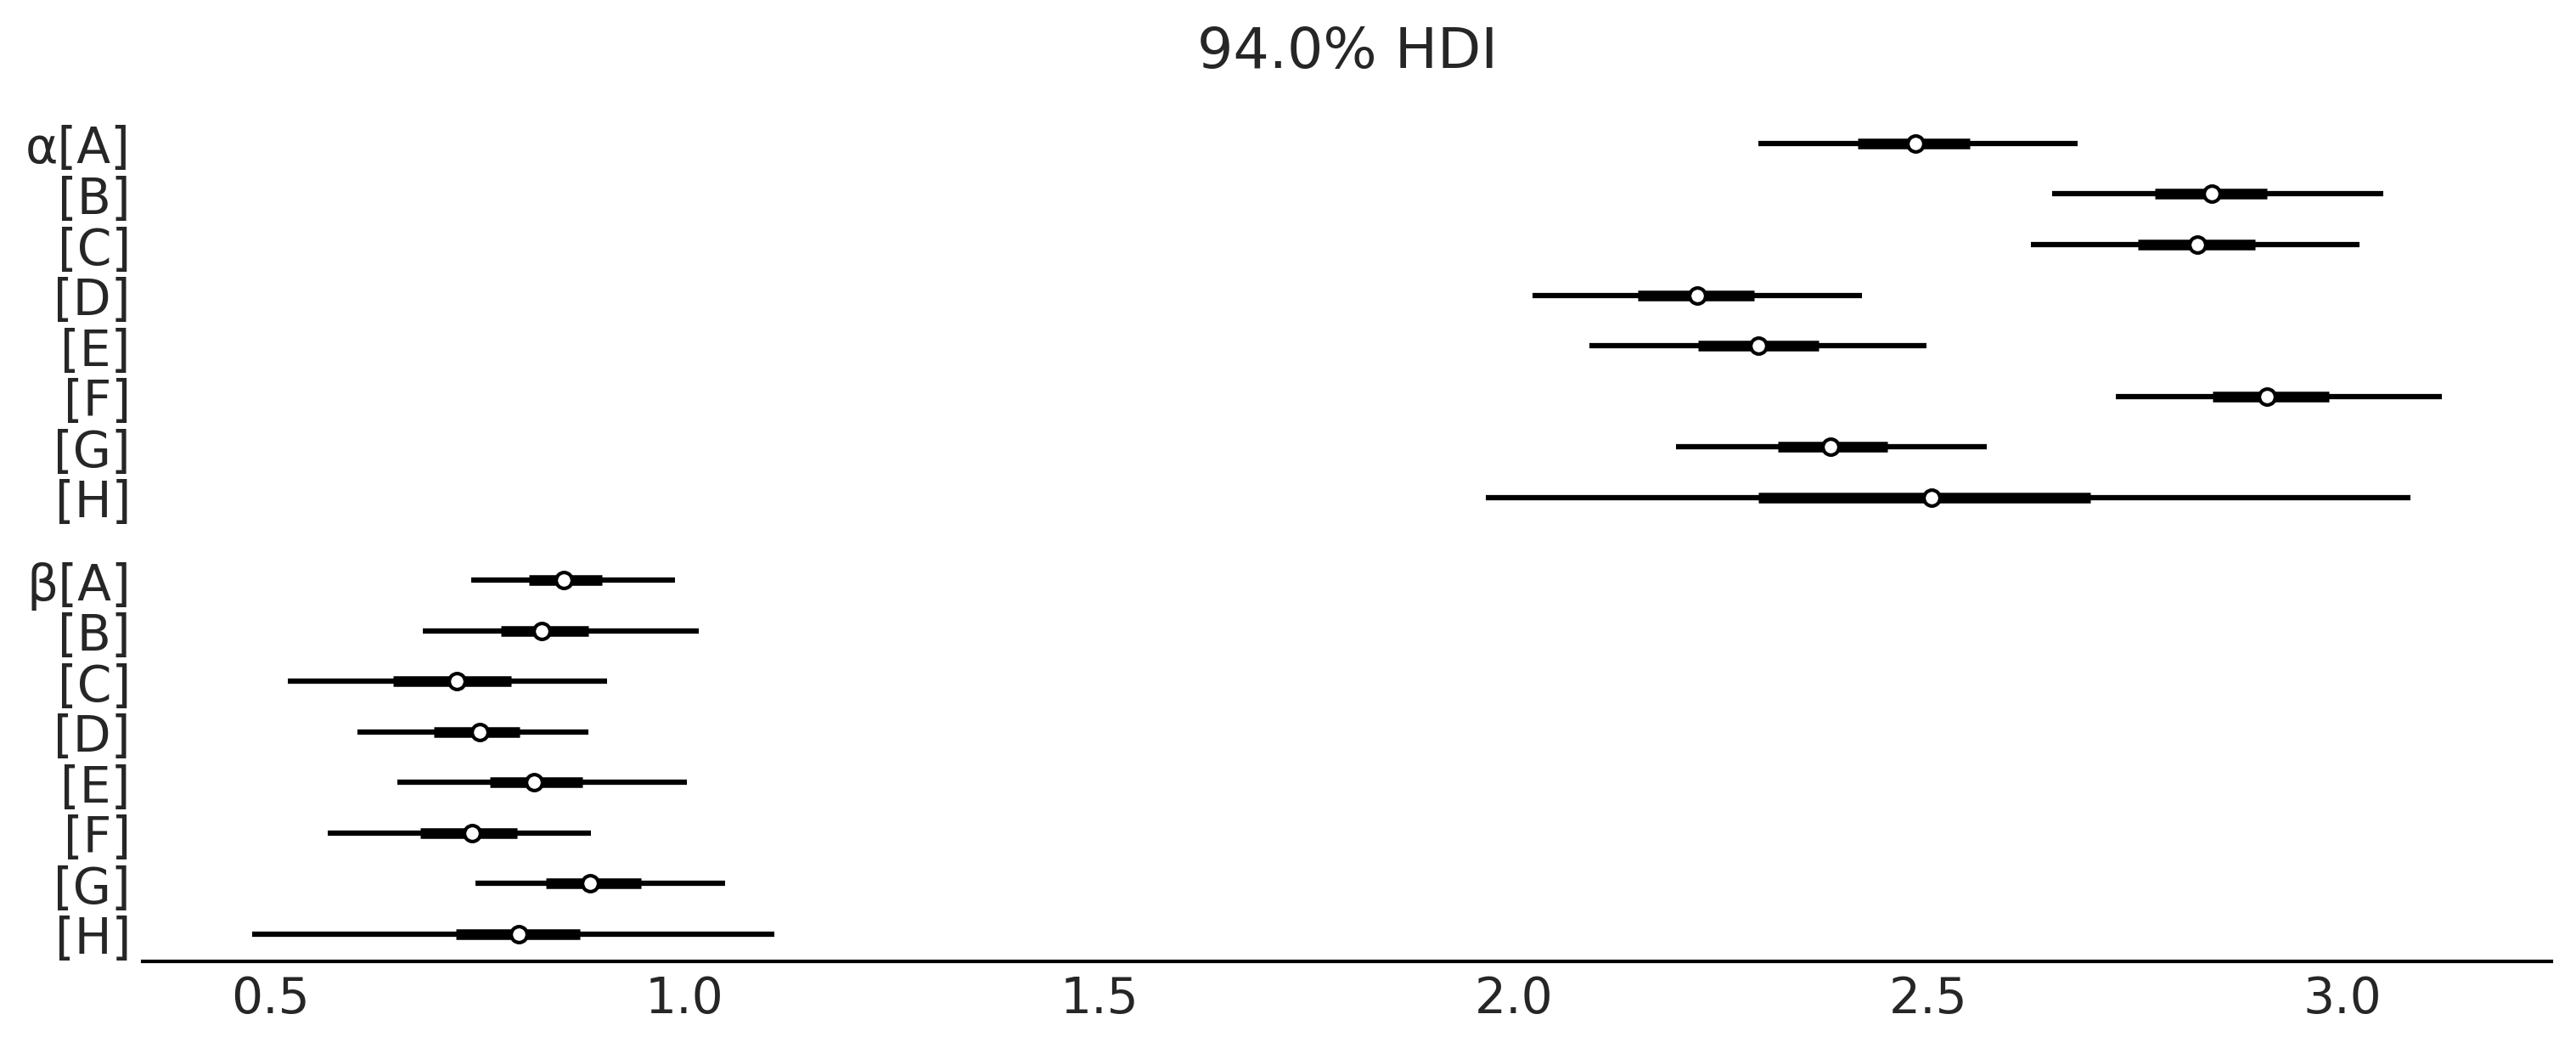

In [37]:
az.plot_forest(idata_ncen, var_names=["α", "β"], combined=True, figsize=(10, 4))
plt.savefig("../fig/hierarchical_non_centered_forest.png")

/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=Fals

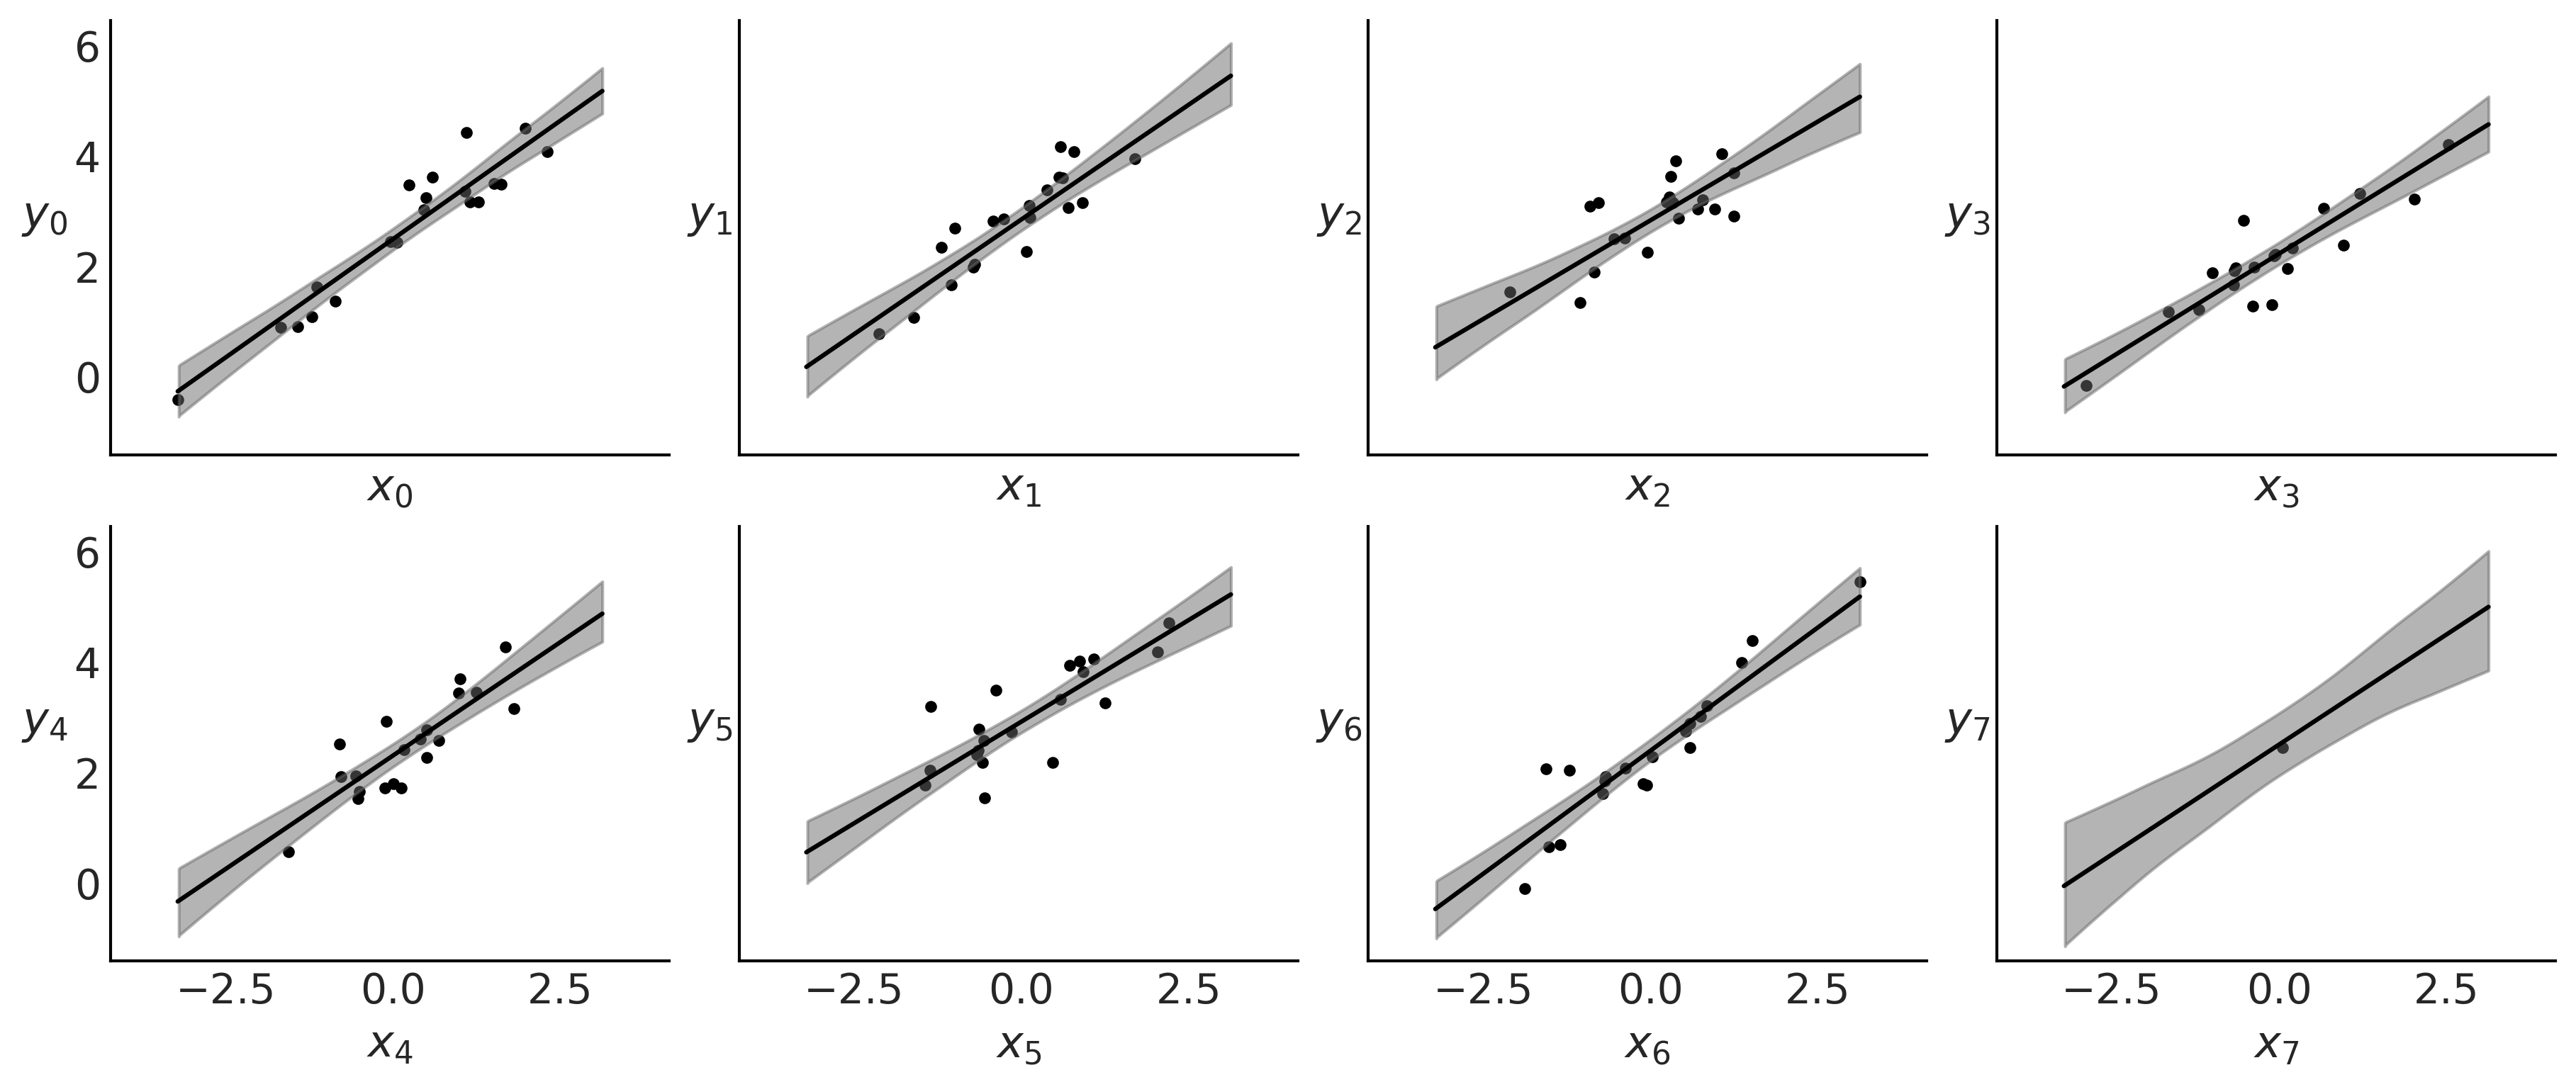

In [38]:
_, ax = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
posterior = az.extract(idata_ncen)

for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_xlabel("$x_{}$".format(i))
    ax[i].set_ylabel("$y_{}$".format(i), labelpad=10, rotation=0)
    alfas = posterior["α"].sel(group=g)
    betas = posterior["β"].sel(group=g)
    alfa_m = alfas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    ax[i].plot(x_range, alfa_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alfas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    plt.xlim(x_m.min() - 1, x_m.max() + 1)
    plt.ylim(y_m.min() - 1, y_m.max() + 1)
    j += N
    k += N
plt.savefig("../fig/hierarchical_non_centered_fit.png")

## Multiple linear regression

In [39]:
with pm.Model() as model_mlb:
    α = pm.Normal("α", mu=0, sigma=1)
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * bikes.temperature + β1 * bikes.hour))
    _ = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=bikes.rented)

    idata_mlb = pm.sample(random_seed=123)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β0, β1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [40]:
idata_neg.posterior["β0_scaled"] = idata_neg.posterior["β"] * bikes.temperature.std()

idata_mlb.posterior["β0_scaled"] = idata_mlb.posterior["β0"] * bikes.temperature.std()
idata_mlb.posterior["β1_scaled"] = idata_mlb.posterior["β1"] * bikes.hour.std()

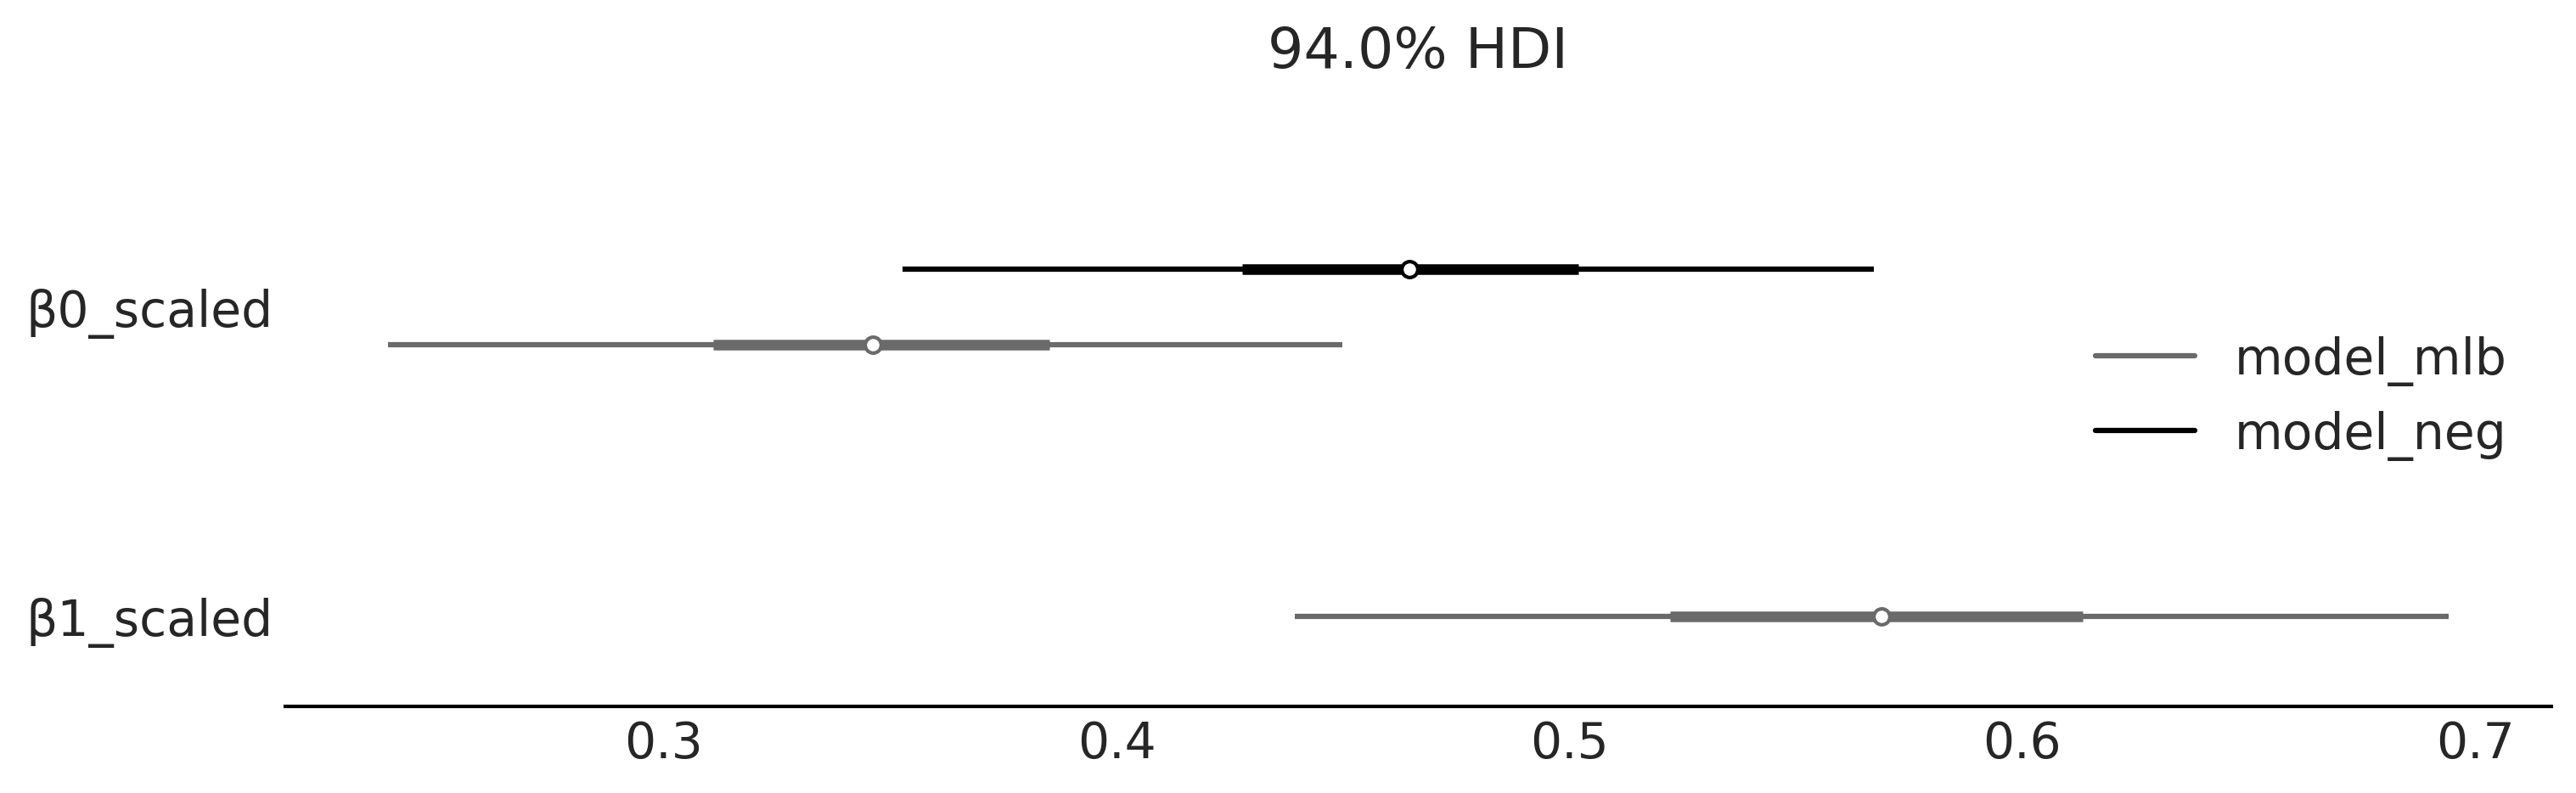

In [41]:
az.plot_forest([idata_neg, idata_mlb], model_names=["model_neg", "model_mlb"],
var_names=["β0_scaled", "β1_scaled"], figsize=(10, 3), combined=True)
plt.savefig("../fig/neg_vs_mlb.png")